In [329]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [330]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import innvestigate

from keras.models import load_model
from keras import backend as K
from keras.utils import Sequence

import sys
sys.path.append("../")
from utils import load_nifti, normalize_float, IntensityRescale, replace_classifier, get_labels_dict, heatmap_per_region, aggregate_regions
from config import *

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "5"
set_session(tf.Session(config=config))

In [5]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/remove_lesions/valverde/"

In [287]:
atlas_labels_path = "/analysis/fabiane/scaled_nmm_order0.nii"
atlas_labels = load_nifti(atlas_labels_path)

wm_atlas_path = "/analysis/fabiane/scaled_JHU_WM_order0.nii"
wm_atlas = load_nifti(wm_atlas_path)

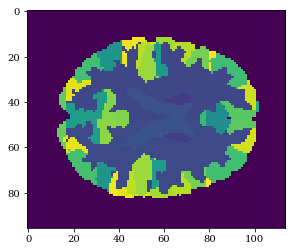

In [75]:
plt.imshow(atlas_labels[:,:,48])
plt.show()

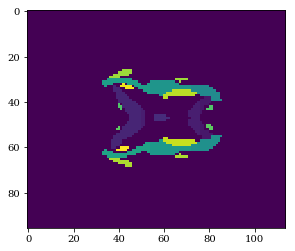

In [288]:
plt.imshow(wm_atlas[:,:,48])
plt.show()

In [27]:
# load hdf5 files and extract columns
#train_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset.h5', 'r')
#holdout_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset.h5', 'r')

#X_train, y_train = train_h5['X'], train_h5['y']
#X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

# load hdf5 including edss
train_h5 = h5py.File('/analysis/ritter/data/MS/CIS/train_dataset_FLAIR_lesions_filled_valverde.h5', 'r')
holdout_h5 = h5py.File('/analysis/ritter/data/MS/CIS/holdout_dataset_FLAIR_lesions_filled_valverde.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

train_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/train_dataset_lesions.h5', 'r')
holdout_lesions_h5 = h5py.File('/analysis/fabiane/data/MS/explMS/holdout_dataset_lesions.h5', 'r')

lesion_masks_train = train_lesions_h5['masks']
lesion_masks_holdout = holdout_lesions_h5['masks']

In [28]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 120
Number of healthy controls: 59
Number of MS patients: 61


In [29]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None, include_arbtr=False, **kwargs):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        self.include_arbtr = include_arbtr
        #self.kwargs = kwargs["edss"]
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        if not self.include_arbtr:
            return image, label
        else:
            arbtr = self.kwargs[idx * self.batch_size:(idx + 1) * self.batch_size]
            return image, label, arbtr
    
    def on_epoch_end(self):
        if self.shuffle:
            if not self.include_arbtr:
                self.X, self.y = shuffle(self.X, self.y)
            else:
                self.X, self.y, self.kwargs = shuffle(self.X, self.y, self.kwargs)

## Make dataset

In [30]:
intensity = IntensityRescale(masked=False)

In [31]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


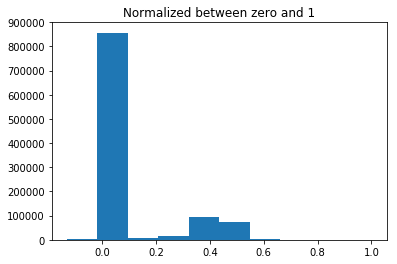

In [32]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


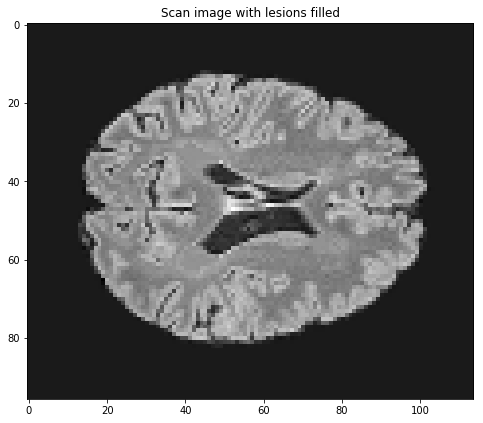

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Scan image with lesions filled")
plt.imshow(np.squeeze(cis_data[9][0][0])[:,:,48], cmap='gray')
plt.show()

In [34]:
lesion_masks_train.shape

(124, 96, 114, 96)

# Model

In [35]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [36]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_6.h5"
model_path = "/analysis/fabiane/models/ADNI/explMS/model_trial_6.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [37]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [38]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [39]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0010960017098113894


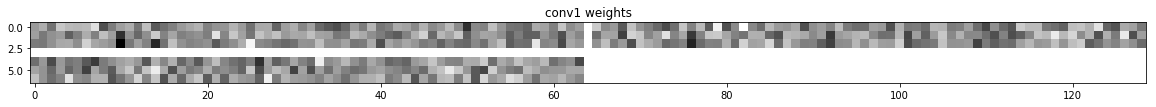

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.0017673493130132556


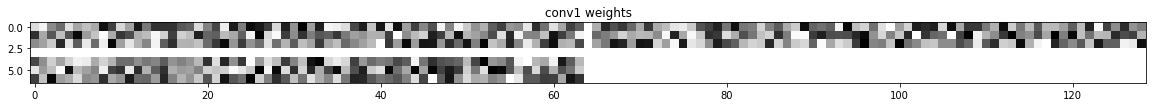

In [40]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

# Visualization

In [41]:
def plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis):
    r = 2
    c = 2
    # Displaying the gradient
    plt.figure(figsize=(14,12))
    plt.subplots_adjust(hspace=0.15, wspace=0.)
    ax1 = plt.subplot(r, c, 1)
    plt.imshow(X_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Scan")
    ax2 = plt.subplot(r, c, 2)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.title("Lesion mask")
    ax3 = plt.subplot(r, c, 3)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(lesion_masks_holdout[image_idx,:,:,sl].squeeze(), cmap='Reds', alpha=0.6, vmin=0.1)
    plt.title("Lesion mask over scan")
    ax4 = plt.subplot(r, c, 4)
    plt.imshow(image[0,:,:,sl].squeeze(), cmap='gray', interpolation=None)
    plt.imshow(analysis.squeeze()[:,:,sl], cmap='Reds', interpolation='nearest', alpha=0.6)
    plt.title("Heatmap overlayed")
    plt.show()

In [42]:
num_trials = 10
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [43]:
import keras.layers
import keras.models
import keras.utils

import innvestigate.utils as iutils

In [44]:
best_model_idx = 4

In [45]:
model = load_model(model_path)
#model = replace_classifier(model, activation='tanh', units=1)
model = replace_classifier(model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[best_model_idx]) # select best model
#model_dir = os.path.join(result_dir, weights[1]) # select other model
model.load_weights(model_dir)

In [46]:
image_idx = 8
sl = 48
b = 1
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=b, shuffle=False, z_factor=z_factor)
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [47]:
print(label)

[1]


In [46]:
image.shape

(1, 96, 114, 96, 1)

In [47]:
pred = model.predict(image)
print("Model prediction: {} with final output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 1 with final output: 4.0132


In [48]:
lesion_masks_holdout.shape

(23, 96, 114, 96)

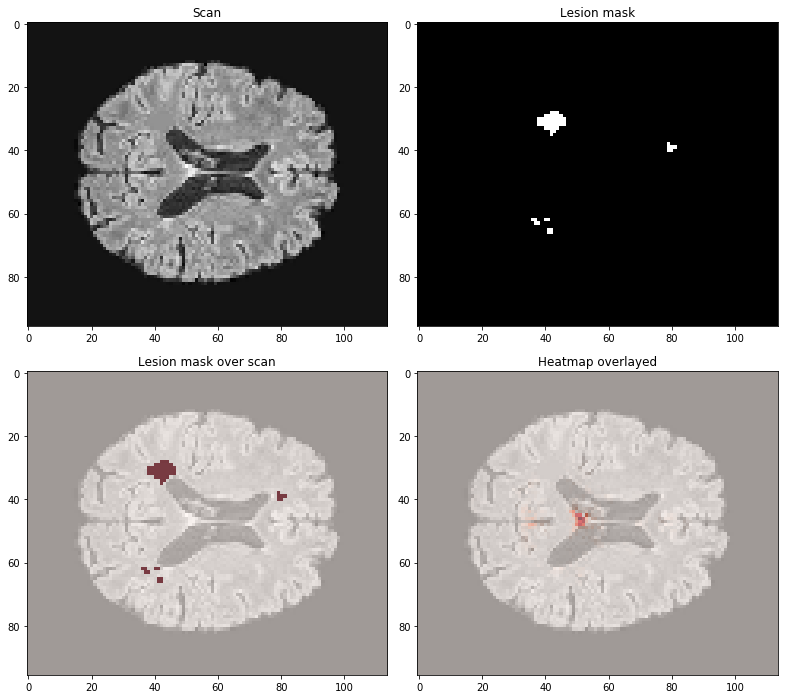

In [49]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [50]:
def heatmap_lesion_similarity(heatmap, lesions, intensity=True, plot=False):
    assert(heatmap.shape == lesions.shape)
    hm = np.copy(heatmap)
    hm = heatmap/np.max(heatmap)
    sl = 48
    if not intensity:
        #thresh = np.max(heatmap)/20
        # threshold hard to fix.. better use with intensities
        thresh = np.max(heatmap)/(6)
        #thresh = 1e-4
        hm[np.where(heatmap>thresh)] = 1.
        hm[np.where(heatmap<=thresh)] = 0.
    if plot:
        plt.imshow(hm[:,:,sl], cmap='gray')
        plt.show()
    l = lesions * hm
    similarity = np.sum(l)
    if not intensity:
        similarity /= np.sum(lesions)
    return similarity

In [51]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

6.096751921101031


In [52]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

0.0


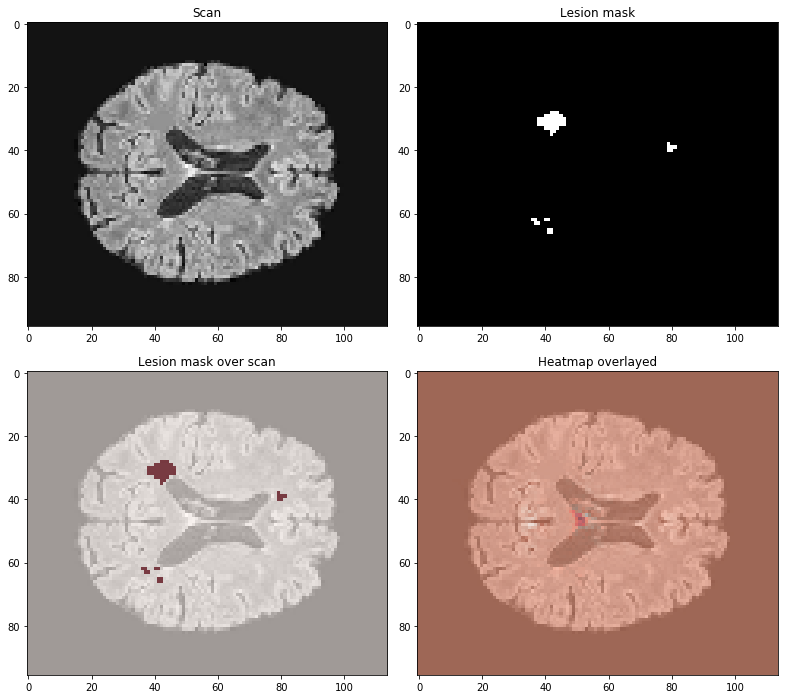

In [53]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

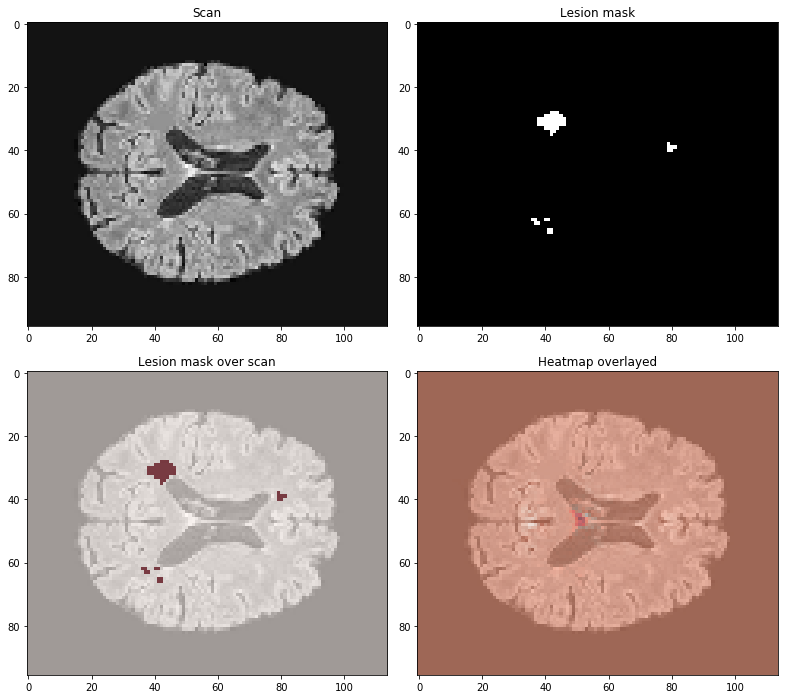

In [54]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

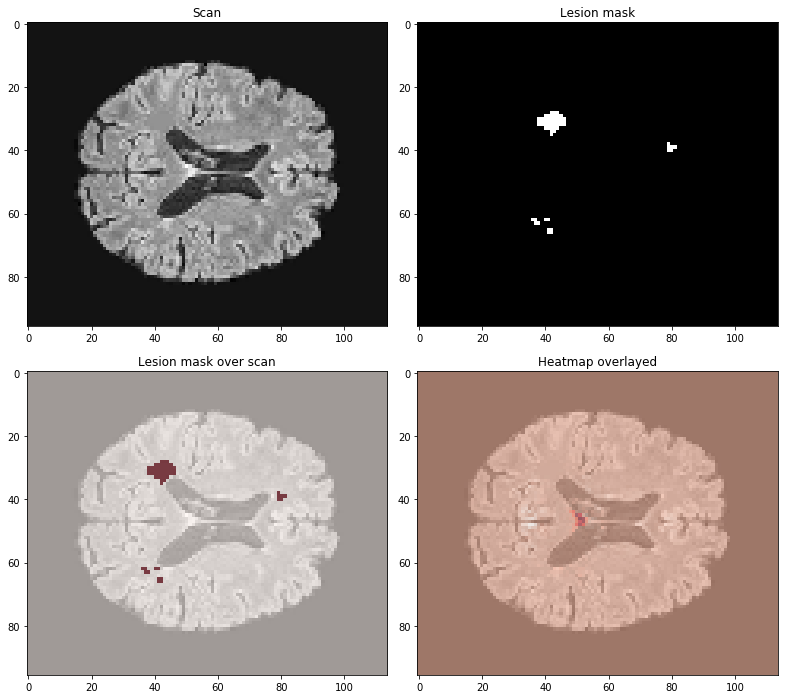

In [55]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

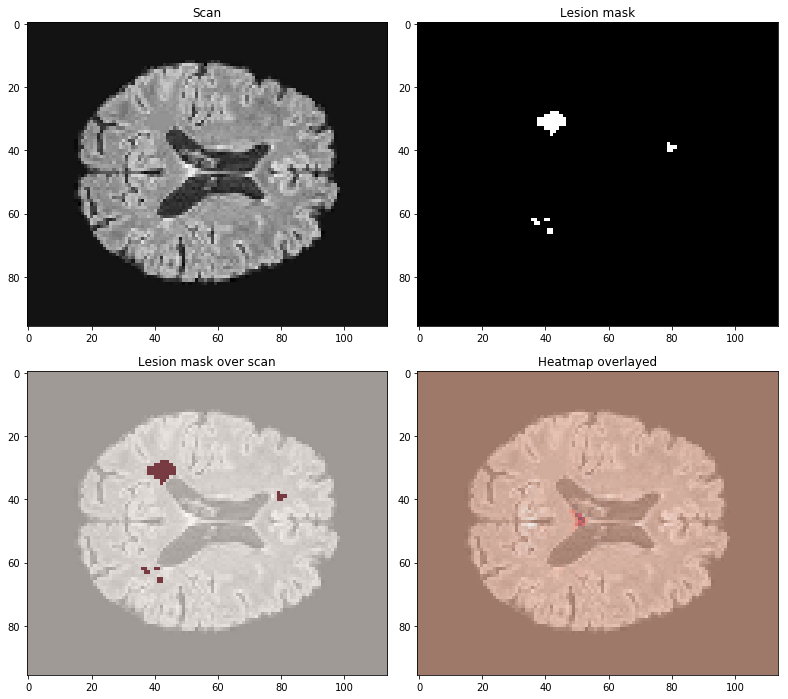

In [56]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [57]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

2.0114844093466218
0.0


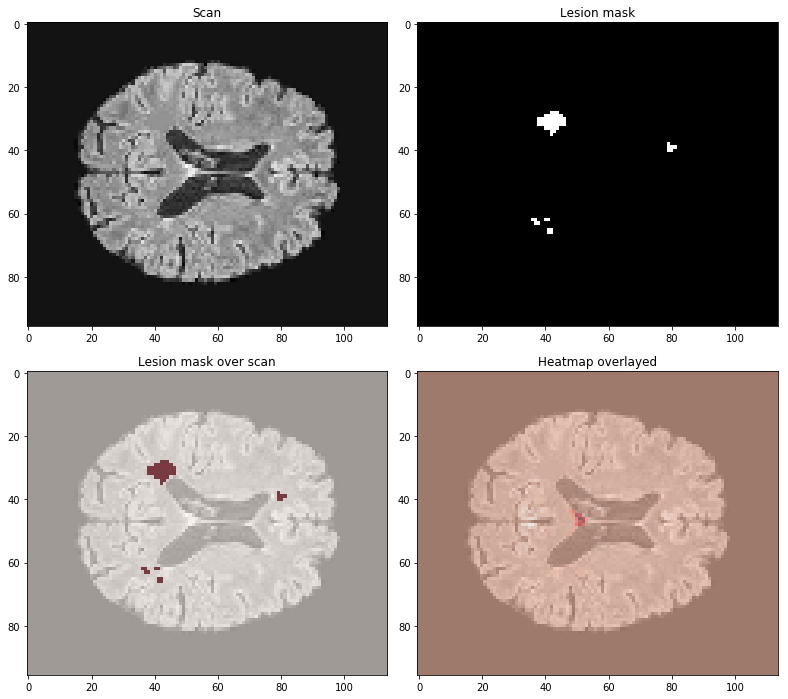

In [58]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=0.001)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [59]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

1.8556830502072899
0.0


## Using only the pre-trained model / no fine-tuning

In [43]:
# loading pre-trained model
model = load_model(model_path)
model = replace_classifier(model, activation=None, units=1)

In [44]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [45]:
print(label)

[1]


In [46]:
pred = model.predict(image)
print("Model prediction: {} with final simgoid output: {:.4f}".format((pred.item()>=0.5)*1, pred.item()))

Model prediction: 0 with final simgoid output: 0.1290


In [47]:
image.shape

(1, 96, 114, 96, 1)

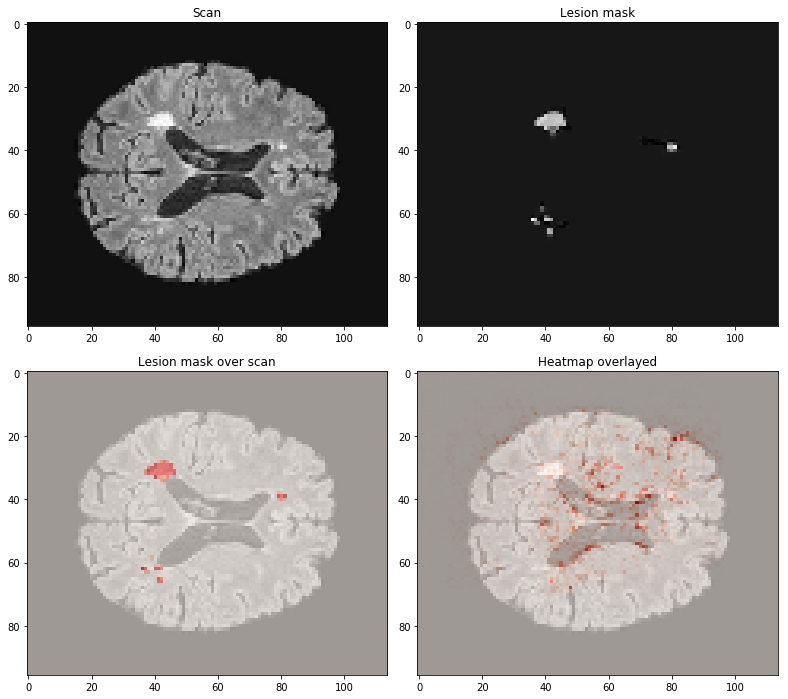

In [48]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [49]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

0.03500898217269412


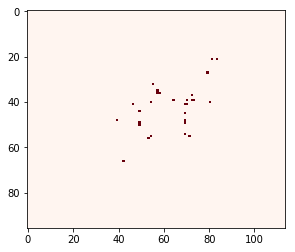

0.02656913015576147


In [50]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

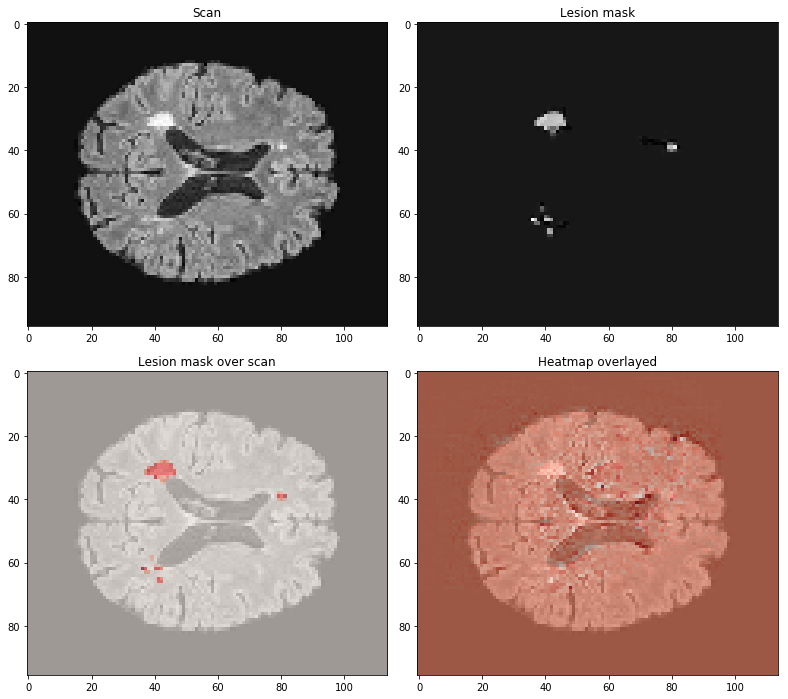

In [51]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

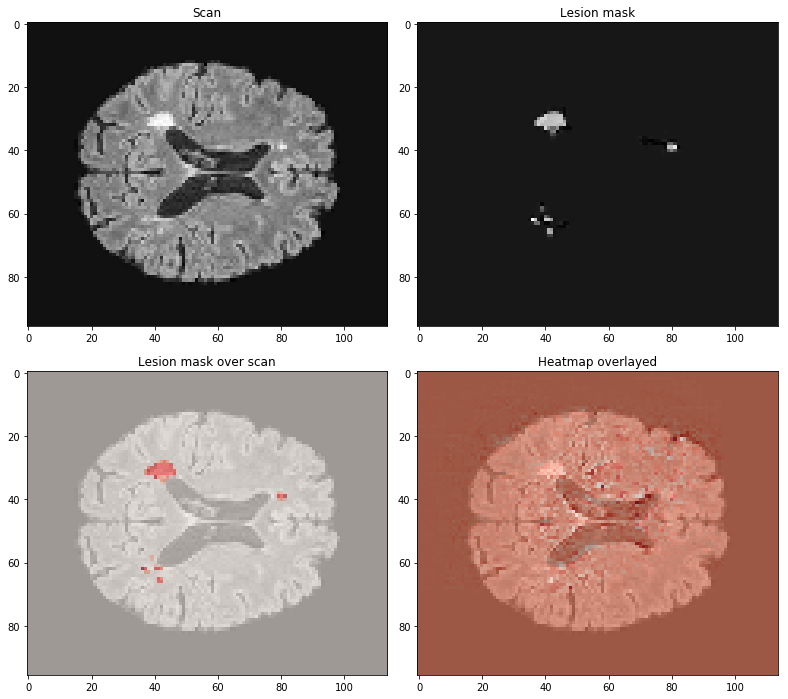

In [52]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

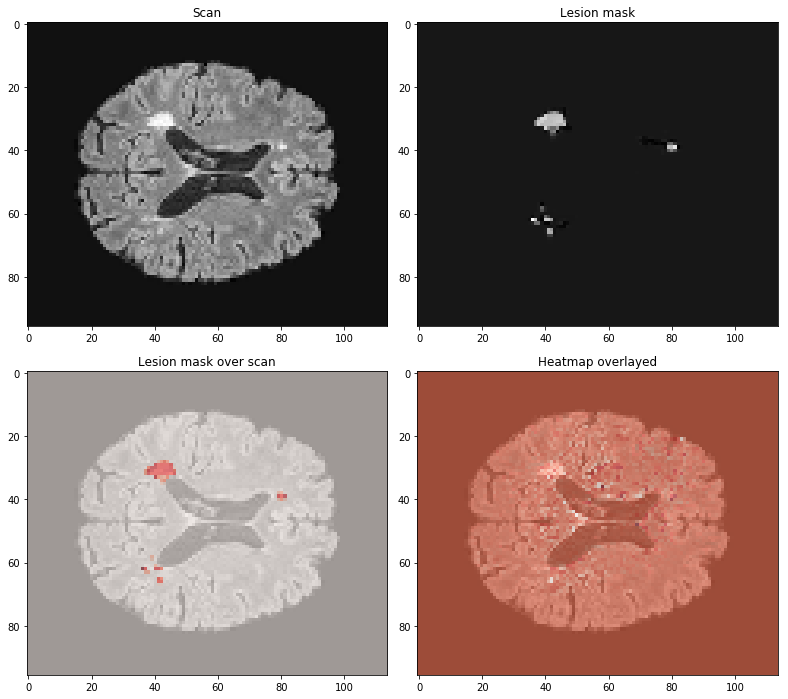

In [53]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

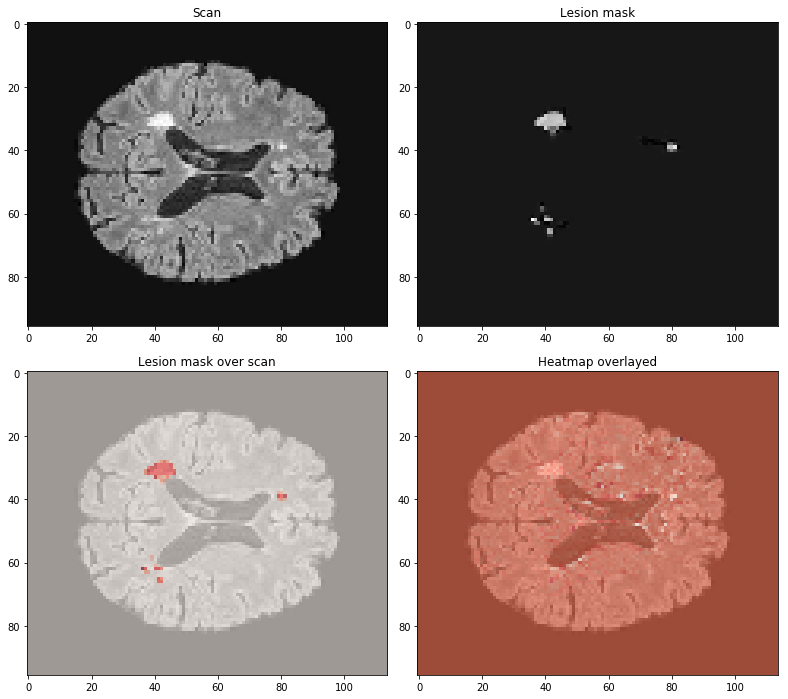

In [54]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

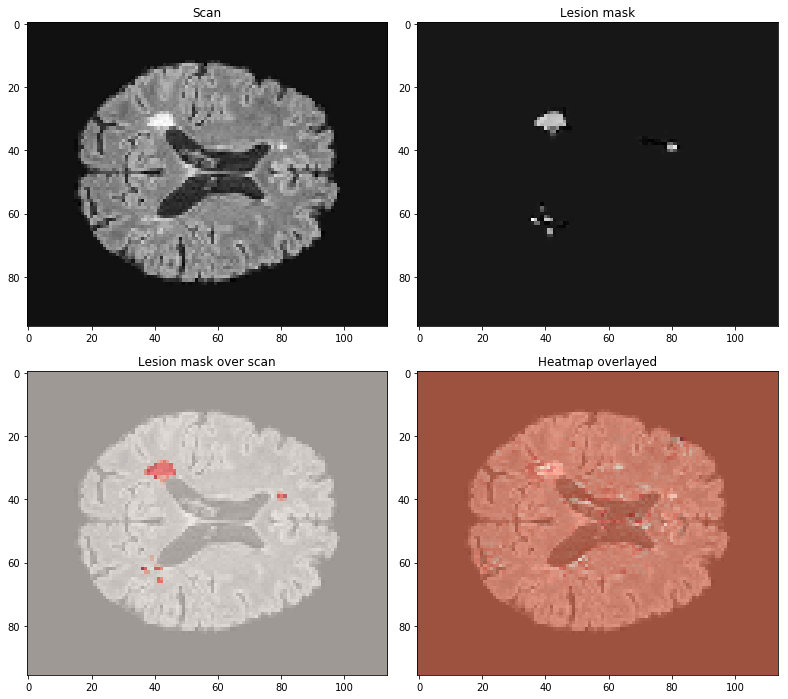

In [55]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

## Random weights

In [56]:
# use random weights
model = load_model(model_path)
reset_weights(model)

In [57]:
image = test_loader[image_idx][0][[0]]
label = test_loader[image_idx][1][[0]]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [58]:
print(label)

[1]


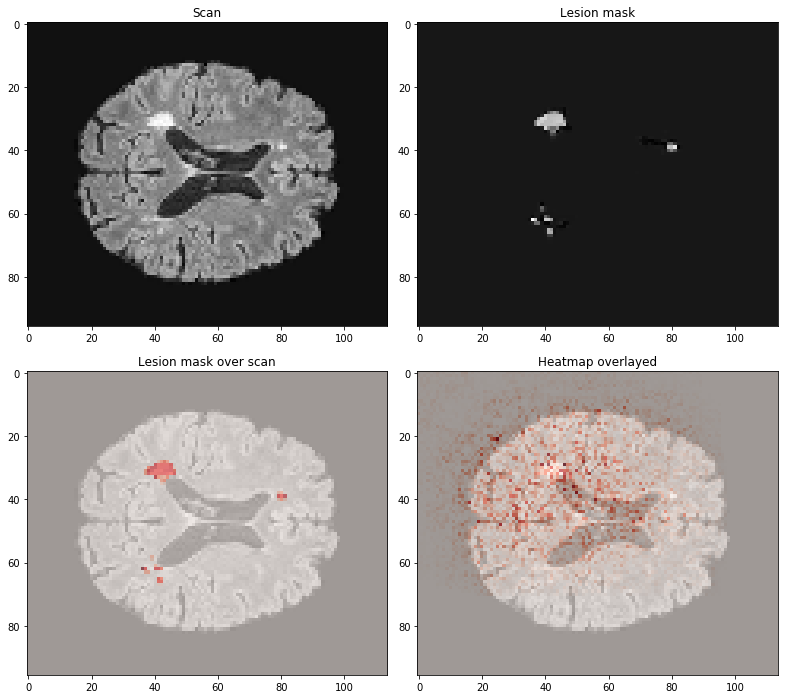

In [59]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

In [60]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx]))

0.10814946932365635


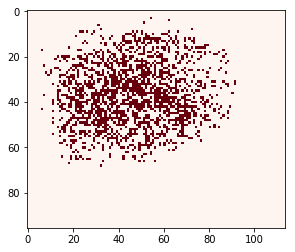

0.4016125341692888


In [61]:
print(heatmap_lesion_similarity(analysis.squeeze(), lesion_masks_holdout[image_idx], intensity=False))

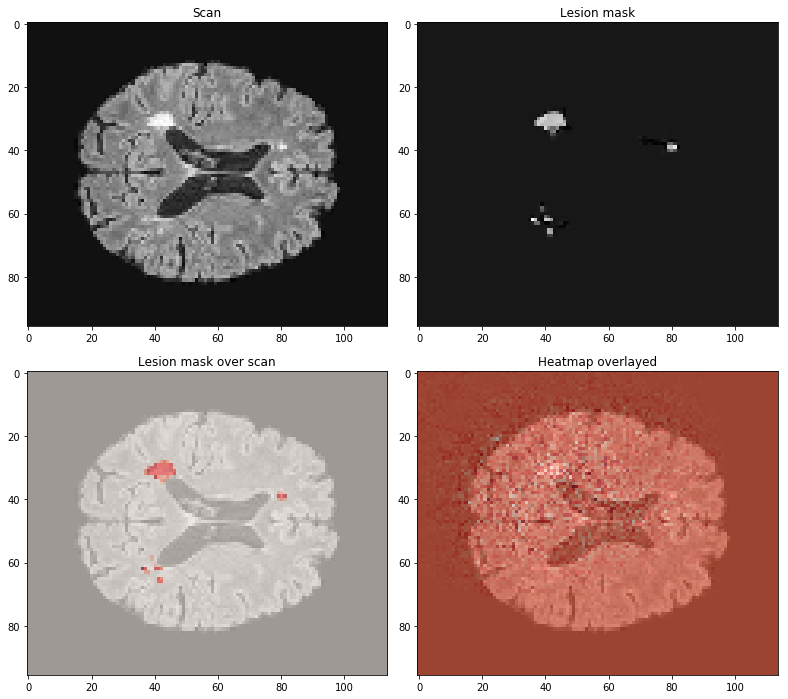

In [62]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("deconvnet", model)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

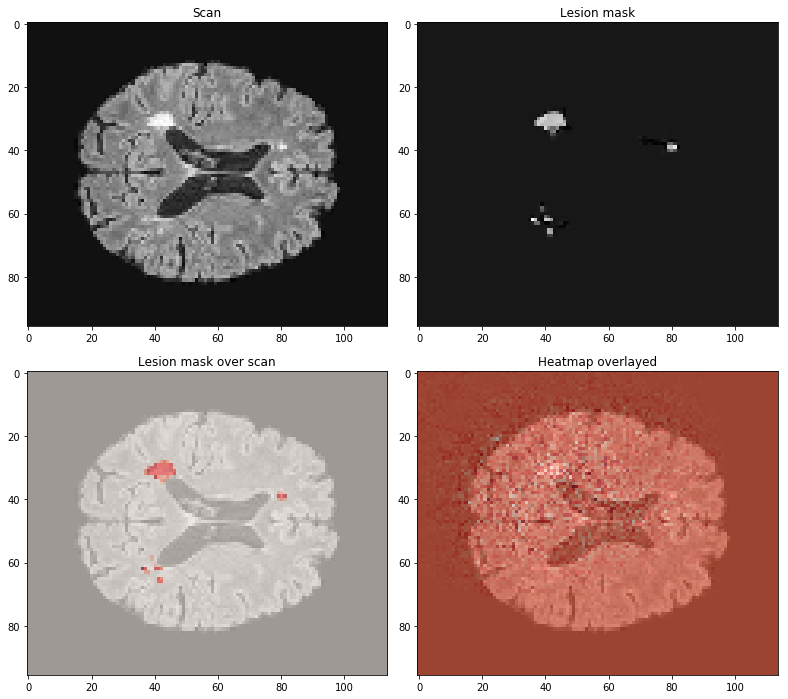

In [63]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("guided_backprop", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

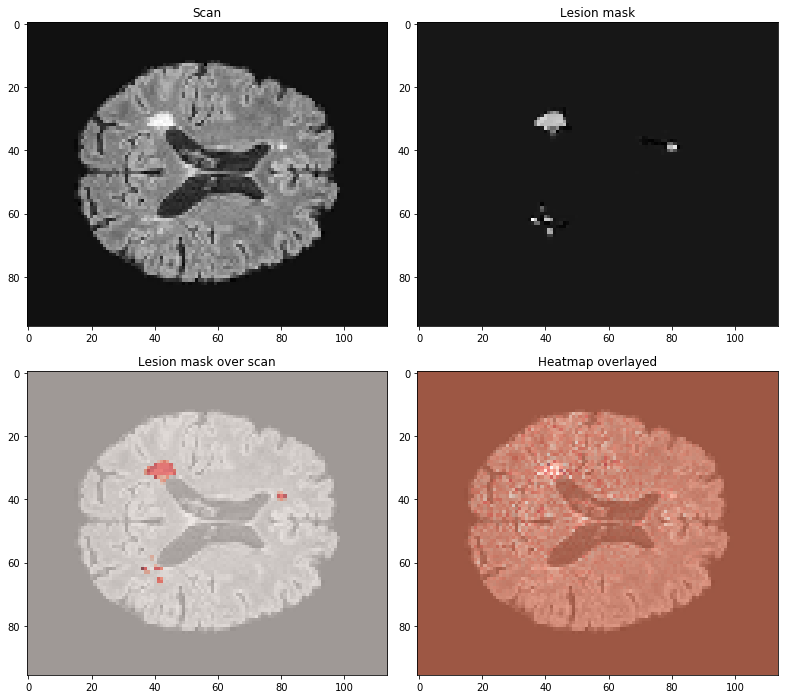

In [64]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("input_t_gradient", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

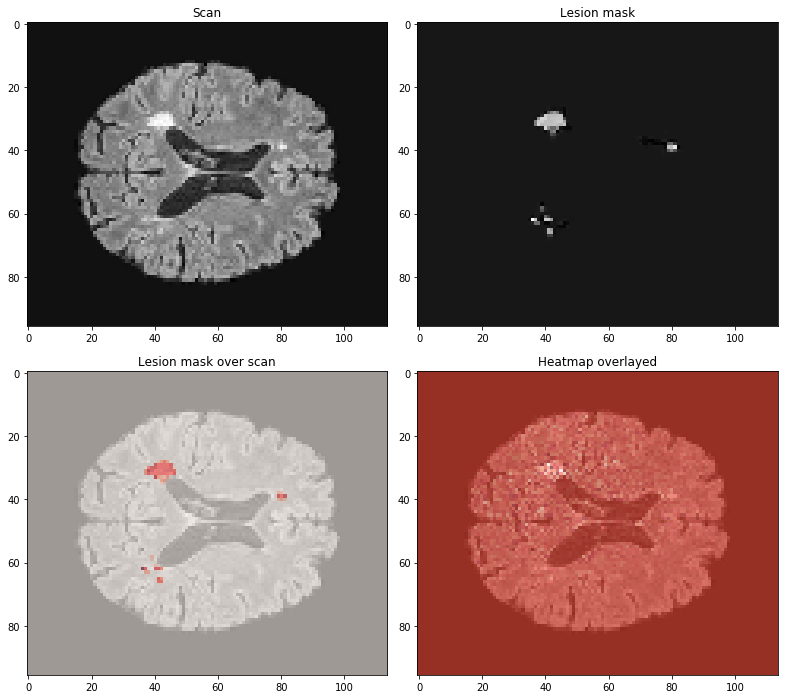

In [65]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.z", model)#, postprocess="abs")

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

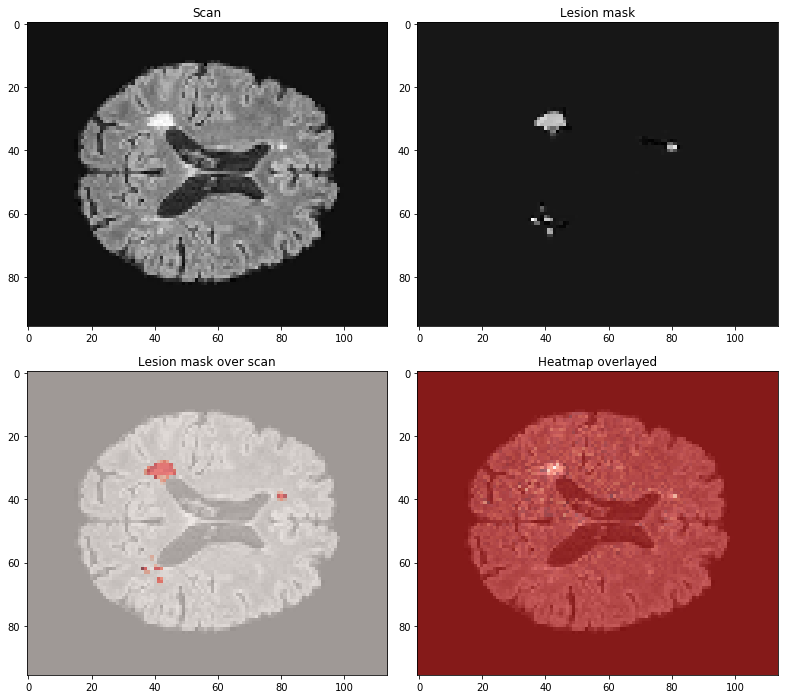

In [66]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

# Applying the analyzer
analysis = gradient_analyzer.analyze(image)

# Visualize
plot_overlay(image, image_idx, X_holdout, lesion_masks_holdout, analysis)

# Main part

### Loading different models

In [48]:
# pre-trained model
pre_trained_model = load_model(model_path)
pre_trained_beheaded_model = replace_classifier(pre_trained_model, activation=None, units=1) # use logits

# fine-tuned model
fine_tuned_model = load_model(model_path)
fine_tuned_beheaded_model = replace_classifier(fine_tuned_model, activation=None, units=1) # use logits
model_dir = os.path.join(result_dir, weights[best_model_idx]) # select best model
fine_tuned_beheaded_model.load_weights(model_dir)
fine_tuned_model.load_weights(model_dir)

# trained from scratch model
scratch_model = load_model(model_path)
scratch_beheaded_model = replace_classifier(scratch_model, activation=None, units=1) # use logits
scratch_path = '/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_from_scratch/'
model_dir = os.path.join(scratch_path, weights[2]) # select best model
scratch_beheaded_model.load_weights(model_dir)
scratch_model.load_weights(model_dir)

# un-trained model
random_model = load_model(model_path)
random_beheaded_model = replace_classifier(random_model, activation=None, units=1) # use logits
reset_weights(random_beheaded_model)
reset_weights(random_model)

### Creating special transparent colormap

In [49]:
from matplotlib.colors import LinearSegmentedColormap
# copy from existing colormap
ncolors = 256
color_array = plt.get_cmap('coolwarm')(range(ncolors))

# create parabolic decrease 
decr = [-1*(x**2)+1 for x in range(int(ncolors/2))]
# normalize
decr = (decr - np.min(decr))/(np.max(decr - np.min(decr)))

#plt.plot(decr)
#plt.ylim(0, 1)
#plt.show()

# use inverted parabola as increase
incr = np.copy(decr)[::-1]
alphas = np.concatenate((decr, incr))
# update alpha values
color_array[:,-1] = alphas

# create new colormap and register it
transparent_coolwarm = LinearSegmentedColormap.from_list('TransCoWa', color_array)
plt.register_cmap(cmap=transparent_coolwarm)

### Plotting functions

In [50]:
image_file_dir = "/analysis/fabiane/documents/publications/MS_CNN_VIS"

In [51]:
mask = np.expand_dims(load_nifti("/analysis/ritter/data/MS/Test/alt/zoomed_mask2.nii.gz", z_factor=z_factor), 3)

In [52]:
mask[mask <1e-5] = 0.0

In [53]:
test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [54]:
train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None)

In [55]:
def plot_heatmap(heatmap, scan_avg, vmin, vmax, title="Heatmap sum", cmap='seismic', sl=(48, 60, 48), show_average=True):
    vmin = -0.05
    vmax = 0.05
    #vmax = vmin * -1
    #vmin = np.min(heatmap)
    #vmax = np.max(heatmap)
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,:,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 2)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.subplot(2, 3, 3)
    plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.imshow(np.rot90(np.squeeze(heatmap)[sl[2],:,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.colorbar()
    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    plt.show()

In [56]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap2(heatmap, scan_avg, vmin, vmax, title=None, cmap='seismic', sl=((48, 60, 48),), show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of entire individual by iterating over
    slice combinations.
    """
    vmin = -0.03
    vmax = 0.03
    sl_list = list(sl)
    nrows = len(sl_list)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13.49, 4.5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]

    for count, sl in enumerate(sl_list):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9, vmin=0, vmax=1)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.05, 0.01, p2[2], 0.01]) # settings for whole subject
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)   
        
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [57]:
def plot_heatmap_zero_one(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13., 5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):    
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray', alpha=0.9)
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray', alpha=0.9)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=1, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.08, 0.07, p2[2], 0.03]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
    
    
    # ensure colorbar is within plot
    #fig.subplots_adjust(bottom=0.2)
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True)
    plt.show()

In [58]:
def get_heatmap_sum(dataloader, shape, beheaded_model, prediction_model, mode='prediction'):
    """
    Return the total heatmap sum of all subjects within the dataset.
    In the code "one_" stands for prediction class and "zero_" for null class.
    
    Arguments
        mode: Can be one of 'prediction' or 'label'. Former separates
            true positives and true negatives (ignores false
            predictions), latter separates only by label.
        
    """
    
    one_heatmaps = np.zeros(shape=shape)
    zero_heatmaps = np.zeros(shape=shape)
    one_count = 0
    zero_count = 0
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)

    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        pred = (prediction_model.predict(image) > 0.5) * 1.

        # Applying the analyzer
        analysis = gradient_analyzer.analyze(image)

        if mode == 'prediction':
            # Sorting by correct predictions
            if label == 1 and pred == 1:
                one_heatmaps += analysis
                one_count += 1
            elif label == 0 and pred == 0:
                zero_heatmaps += analysis
                zero_count += 1
        elif mode == 'label':
            # Sorting by label
            if label == 1:
                one_heatmaps += analysis
                one_count += 1
            elif label == 0:
                zero_heatmaps += analysis
                zero_count += 1
        
    print("Sorted by {}".format(mode))
    print("total {}".format(len(dataloader)))
    print("one {}".format(one_count))
    print("zero {}".format(zero_count))
    # Average values over number of samples
    one_heatmaps /= one_count
    zero_heatmaps /= zero_count
    
    return one_heatmaps, zero_heatmaps

In [59]:
def get_heatmap_list(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
    return heatmap_list

In [60]:
def get_heatmap_list_with_edss(dataloader, shape, beheaded_model, skip_healthy=False):
    """
    Return a list of heatmaps for all subjects within
    the dataloader.
    """
    heatmap_list = []
    edss = []
    
    # Creating an analyzer
    gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", beheaded_model, epsilon=0.001)
    
    for image_idx in range(len(dataloader)):
        image = dataloader[image_idx][0][[0]]
        label = dataloader[image_idx][1][[0]]
        edss_score = dataloader[image_idx][2][[0]].item()
        
        # skip healthy controls if desired
        if not skip_healthy or label == 1:
            # Applying the analyzer
            analysis = gradient_analyzer.analyze(image)
            heatmap_list.append(analysis)
            edss.append(edss_score)
    return heatmap_list, edss

# Average heatmaps

In [61]:
ms_heatmaps_holdout, hc_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [62]:
ms_heatmaps_train, hc_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 120
one 61
zero 59


In [63]:
TP_heatmaps_holdout, TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 7


In [64]:
TP_heatmaps_train, TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 120
one 56
zero 59


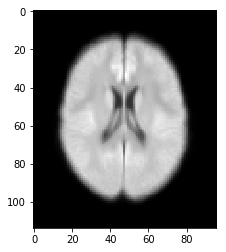

In [65]:
# Create average image for background
avg_train_image = np.mean(X_train, axis=0)
plt.imshow(np.rot90(np.squeeze(avg_train_image)[:,:,48], axes=(0,1)), cmap='gray')
plt.show()

# Holdout averages

### MS vs HC

In [66]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

In [67]:
plt.rc('font', family='serif')

In [68]:
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['serif']))
print(font)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


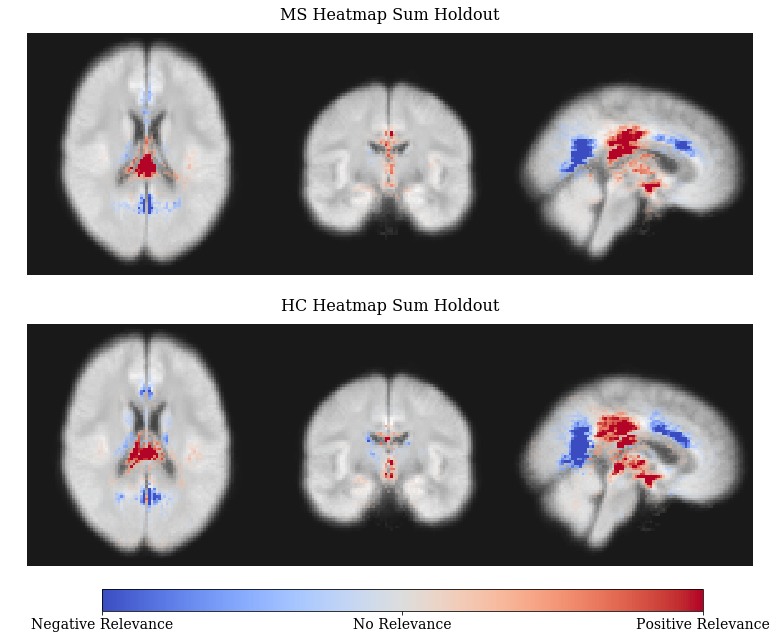

In [69]:
hms = [ms_heatmaps_holdout, hc_heatmaps_holdout]
titles = ["MS Heatmap Sum Holdout", "HC Heatmap Sum Holdout"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

### TP vs TN

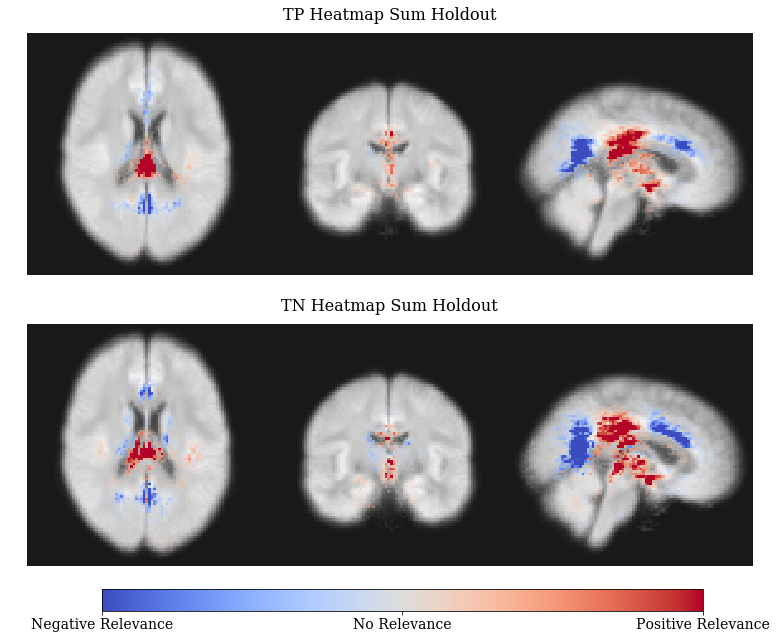

In [70]:
hms = [TP_heatmaps_holdout, TN_heatmaps_holdout]
titles = ["TP Heatmap Sum Holdout", "TN Heatmap Sum Holdout"]
show_cb = True
# fp = os.path.join(image_file_dir, "average_holdout_TP_TN_coolwarm_serif.png")
fp = None
vmin = -0.02
vmax = 0.02
plot_heatmap_zero_one(hms, avg_train_image, vmin, vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

# Atlas analysis

## Neuromorphometrics

In [164]:
labels_dict_path = "/analysis/ritter/misc/masks/Neuromorphometrics/tpm/labels_Neuromorphometrics.xml"
labels_dict = get_labels_dict(labels_dict_path)

In [248]:
# Modified areas from Visualizing evidence for AD paper by Boehle et al.
# Name: (min, max)
all_areas= {
    "Accumbens": (23, 30),
    "Amygdala": (31, 32),
    "Brain Stem": (35, 35),
    "Caudate": (36, 37),
    "Cerebellum": (38, 41),
    "Cerebral White Matter": (44, 45),
    "CSF" : (46, 46),
    "Hippocampus": (47, 48),
    "Parahippocampal gyrus": (170, 171),
    "Pallidum": (55, 56),
    "Putamen": (57, 58),
    "Thalamus": (59, 60),
    "Diencephalon": (61, 62),
    "ACG": (100, 101),
    "Anterior Insula": (102, 103),
    "Posterior Insula": (172, 173),
    "AOG": (104, 105),
    "AAG": (106, 107),
    "Cuneus": (114, 115),
    "Central operculum": (112, 113),
    "Frontal operculum": (118, 119),
    "Frontal pole": (120, 121),
    "Fusiform gyrus": (122, 123),
    "Temporal pole": (202, 203),
    "TrIFG": (204, 205),
    "TTG": (206, 207),
    "Ent": (116, 117),
    "Parietal operculum": (174, 175),
    "SPL": (198, 199),
}

Positive values

In [251]:
regional_hm

{4.0: 3.482771707145697e-07,
 11.0: 1.4873700154491024e-07,
 23.0: 1.6919504980153296e-08,
 30.0: 1.843335533838675e-08,
 31.0: 6.422196352773933e-08,
 32.0: 6.476634530944278e-08,
 35.0: 1.319604776645912e-06,
 36.0: 2.5787210457991574e-07,
 37.0: 2.3899493868658475e-07,
 38.0: 1.627150224408534e-06,
 39.0: 1.0633371709611514e-06,
 40.0: 3.164961973520146e-07,
 41.0: 2.6623975902823495e-07,
 44.0: 1.9574395743431826e-05,
 45.0: 1.5525692078335475e-05,
 46.0: 6.723946870947048e-07,
 47.0: 3.968466878370854e-07,
 48.0: 3.6516677202333414e-07,
 49.0: 2.4452326318241777e-08,
 50.0: 7.741057430056517e-09,
 51.0: 1.644987125934465e-06,
 52.0: 2.5009131451561867e-06,
 55.0: 7.700174778414636e-08,
 56.0: 4.10483081787047e-08,
 57.0: 1.6150392183050772e-07,
 58.0: 2.0093267263945428e-07,
 59.0: 1.8464069336170555e-06,
 60.0: 1.8334830742628552e-06,
 61.0: 1.3525171544847224e-06,
 62.0: 1.5373791778421136e-06,
 63.0: 9.452842465178231e-10,
 64.0: 2.1856298457599565e-09,
 69.0: 1.389715737227173

In [277]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, atlas_labels, positive=True, size_normalize=False)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


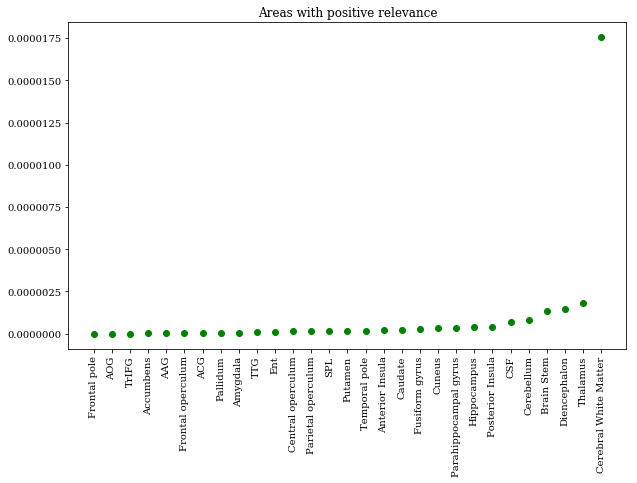

In [278]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("Areas with positive relevance")
plt.show()

Negative values

In [279]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, atlas_labels, positive=False, size_normalize=False)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


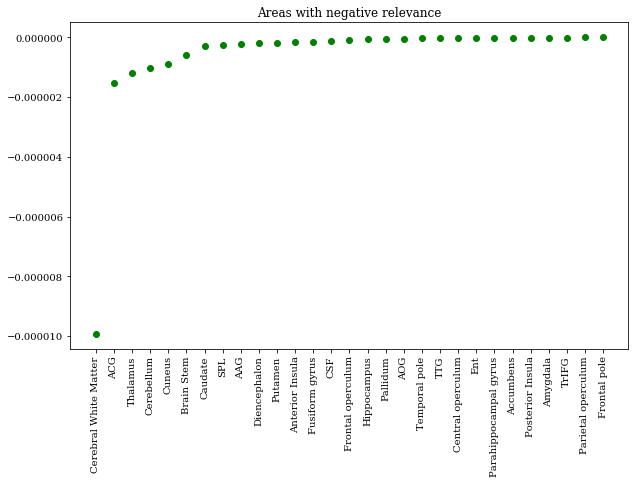

In [280]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("Areas with negative relevance")
plt.show()

Positive values normalized

In [281]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, atlas_labels, positive=True, size_normalize=True)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


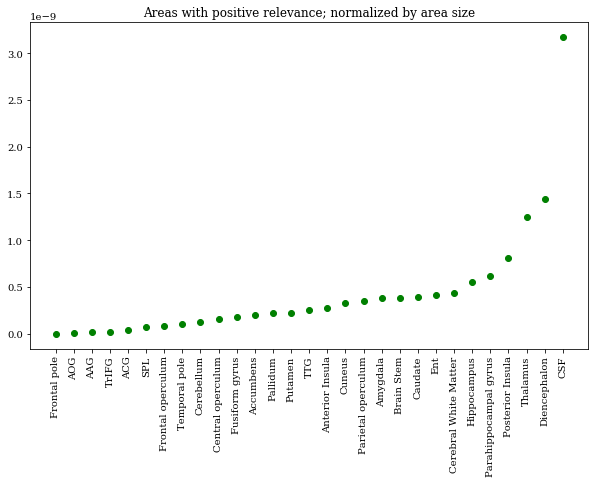

In [282]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("Areas with positive relevance; normalized by area size")
plt.show()

Negative values normalized

In [284]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, atlas_labels, positive=False, size_normalize=True)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


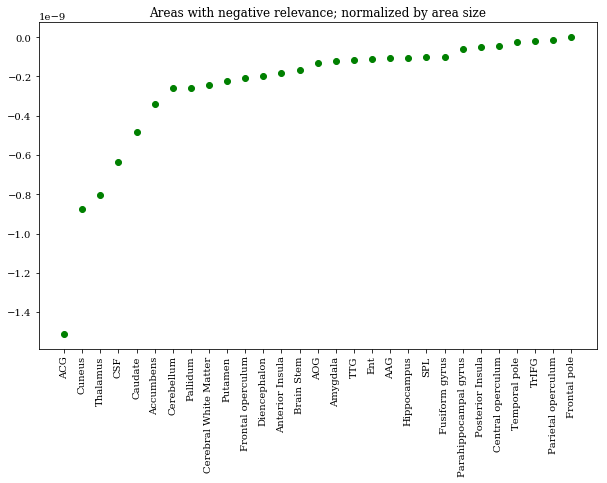

In [286]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("Areas with negative relevance; normalized by area size")
plt.show()

## White matter atlas

In [305]:
def get_labels_dict(path):
    import xmltodict
    with open(path) as f:
        labels_xml = xmltodict.parse(f.read())['atlas']['data']['label']

    labels_dict = {}
    for row in labels_xml:
        try:
            labels_dict[int(row['index'])] = row['@name']
        except:
            try:
                labels_dict[int(row['@index'])] = row["#text"]
            except:
                raise KeyError
    return labels_dict


In [306]:
labels_dict_path = "/analysis/fabiane/atlases/JHU-labels.xml"
labels_dict = get_labels_dict(labels_dict_path)

In [313]:
# Summary of JHU white matter areas
# Name: (min, max)
all_areas= {
    "Middle cerebellar peduncle": (1, 2),
    "Corpus callosum": (3, 5),
    "Fornix": (6, 6),
    "Corticospinal tract": (7, 8),
    "Medial lemniscus": (9, 10),
    "Inferior cerebellar peduncle": (11, 12),
    "Superior cerebellar peduncle": (13, 14),
    "Cerebral peduncle": (15, 16),
    "Anterior limb of internal capsule": (17, 18),
    "Posterior limb of internal capsule": (19, 20),
    "Retrolenticular part of internal capsule": (21, 22),
    "Anterior corona radiata": (23, 24),
    "Superior corona radiata": (25, 26),
    "Posterior corona radiata": (27, 28),
    "Posterior thalamic radiation": (29, 30),
    "Sagittal stratum": (31, 32),
    "External capsule": (33, 34),
    "Cingulum": (35, 38),
    "Superior longitudinal fasciculus": (41, 42),
    "Superior fronto-occipital fasciculus": (43, 44),
    "Uncinate fasciculus": (45, 46),
    "Tapetum": (47, 48),   
}

Positive

In [321]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, wm_atlas, positive=True, size_normalize=False)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


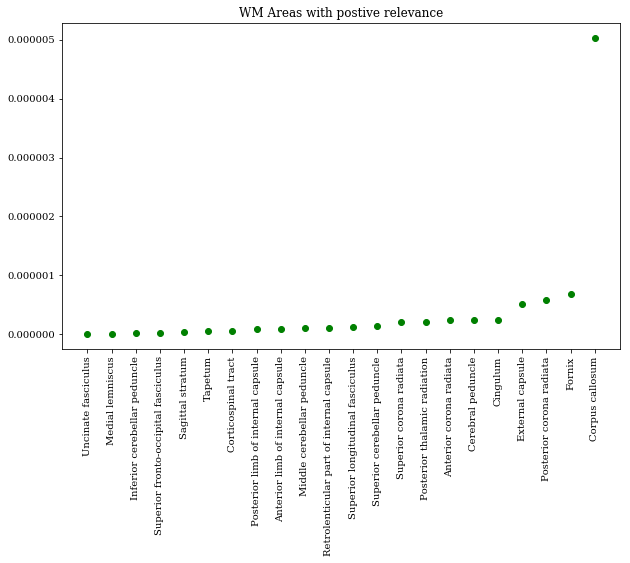

In [322]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("WM Areas with postive relevance")
plt.show()

Positive Normalized

In [324]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, wm_atlas, positive=True, size_normalize=True)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


In [325]:
regional_hm_neg = heatmap_per_region(TN_heatmaps_holdout, wm_atlas, positive=True, size_normalize=True)
area_hm_neg = aggregate_regions(regional_hm_neg, all_areas)
# sort values
area_hm_sorted_neg = sorted(area_hm_neg.items(), key=lambda kv: kv[1])
keys_sorted_neg = [row[0] for row in area_hm_sorted_neg]
values_sorted_neg = [row[1] for row in area_hm_sorted_neg]


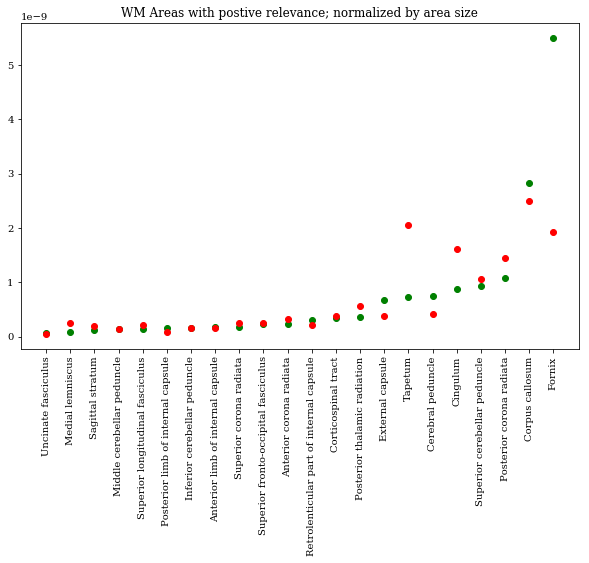

In [328]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.plot(keys_sorted_neg, values_sorted_neg, 'ro')
plt.xticks(rotation='vertical')
plt.title("WM Areas with postive relevance; normalized by area size")
plt.show()

Negative Normalized

In [314]:
regional_hm = heatmap_per_region(TP_heatmaps_holdout, wm_atlas, positive=False, size_normalize=True)
area_hm = aggregate_regions(regional_hm, all_areas)
# sort values
area_hm_sorted = sorted(area_hm.items(), key=lambda kv: kv[1])
keys_sorted = [row[0] for row in area_hm_sorted]
values_sorted = [row[1] for row in area_hm_sorted]


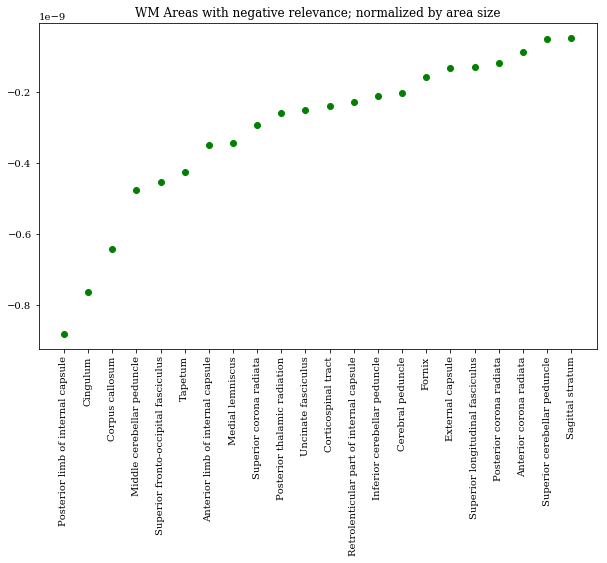

In [317]:
plt.figure(figsize=(10, 6))
plt.plot(keys_sorted, values_sorted, 'go')
plt.xticks(rotation='vertical')
plt.title("WM Areas with negative relevance; normalized by area size")
plt.show()

# Training averages

### MS vs HC

2.561123687125076


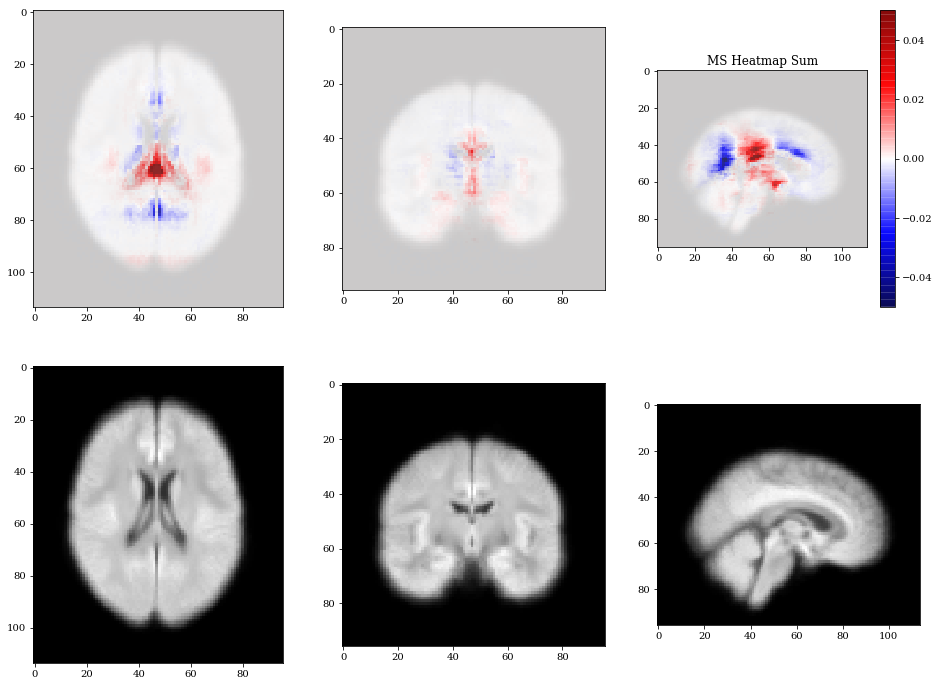

-2.32027460841773


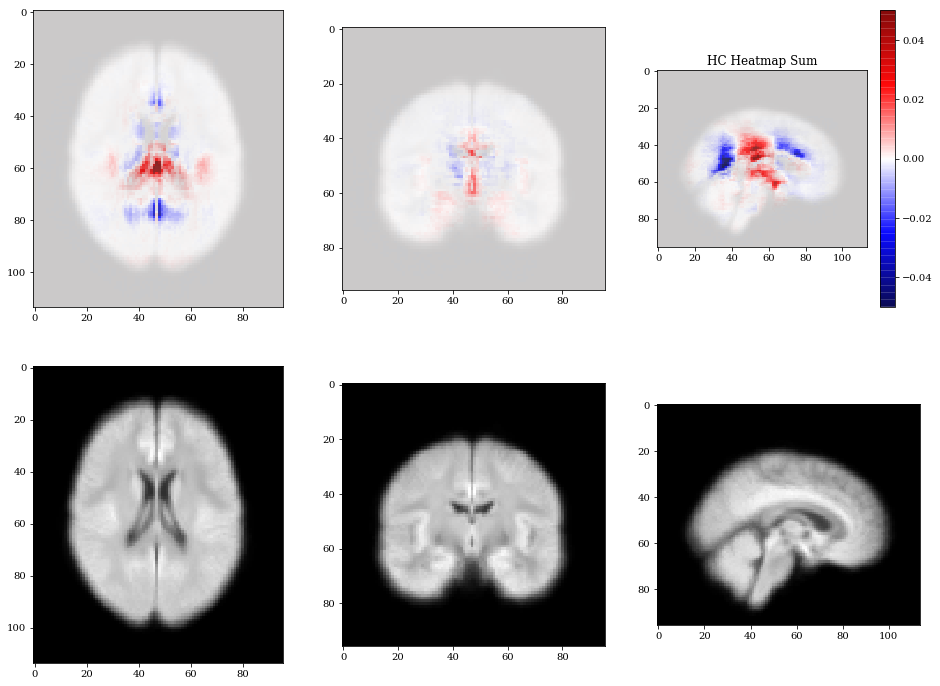

In [88]:
hms = [ms_heatmaps_train, hc_heatmaps_train]
titles = ["MS Heatmap Sum", "HC Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

### TP vs TN

2.8848154388013723


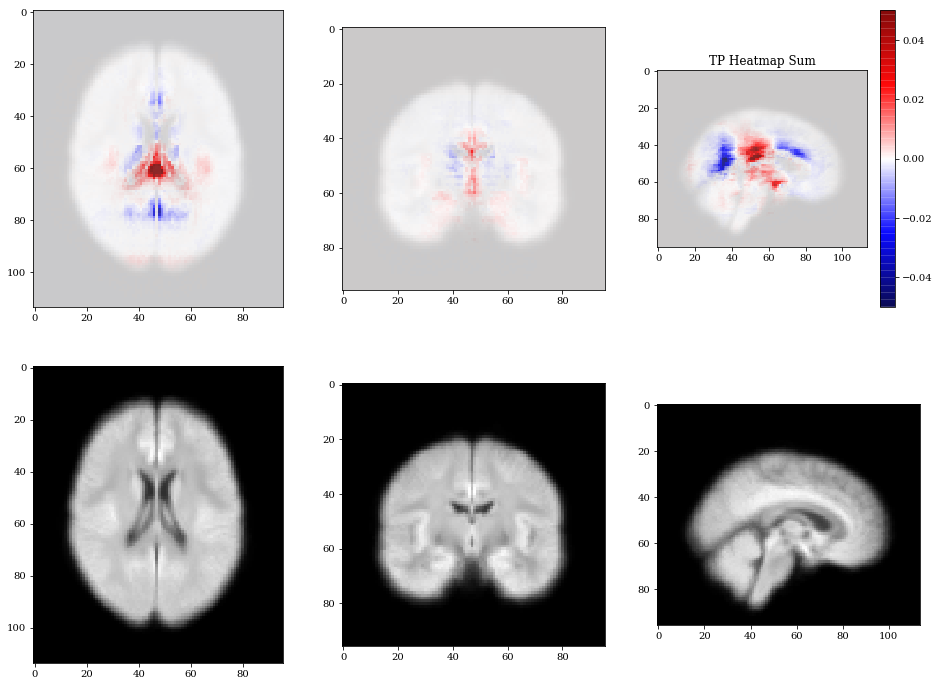

-2.3202745818528863


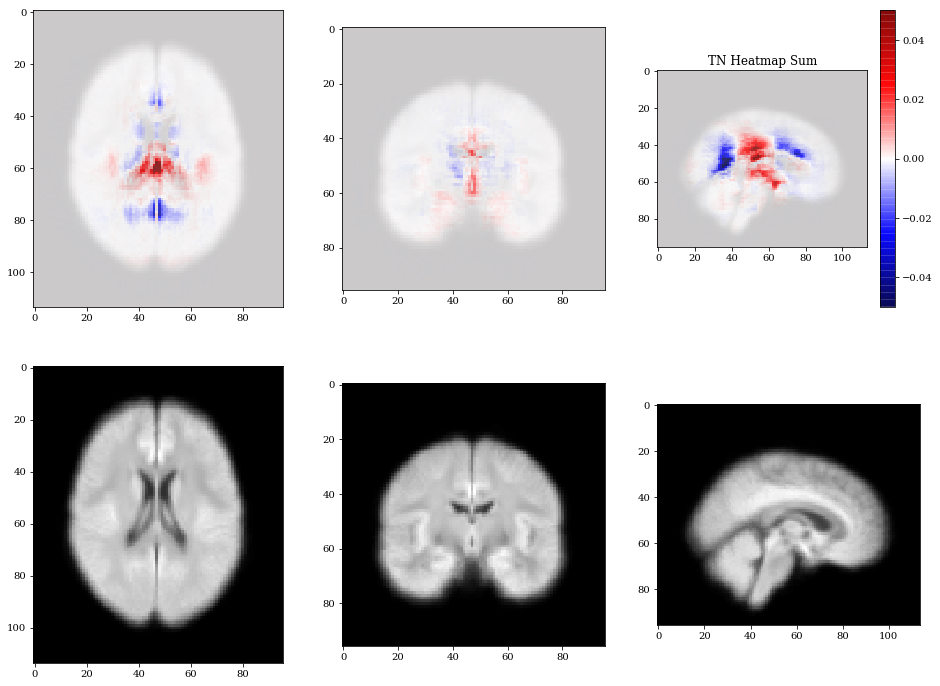

In [89]:
hms = [TP_heatmaps_train, TN_heatmaps_train]
titles = ["TP Heatmap Sum", "TN Heatmap Sum"]
for hm, title in zip(hms, titles):
    print(np.sum(hm))
    plot_heatmap(hm, avg_train_image, vmin, vmax, title, cmap='seismic')

In [710]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

2.4363267745976214
-1.8552411610413297


In [689]:
print(np.sum(ms_heatmaps_train))
print(np.sum(hc_heatmaps_train))

1.966618770852537
-1.8151282016099968


### Gradient based

In [206]:
ms_heatmaps = np.zeros_like(analysis)
hc_heatmaps = np.zeros_like(analysis)
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("gradient", model, postprocess="abs")

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    # Normalize heatmaps
    analysis = (analysis - np.min(analysis))/(np.max(analysis) - np.min(analysis))
    # Sorting by label
    if label == 1:
        ms_heatmaps += analysis
    else:
        hc_heatmaps += analysis

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


In [207]:
# Average values over number of samples
ms_heatmaps /= len(test_loader)
hc_heatmaps /= len(test_loader)

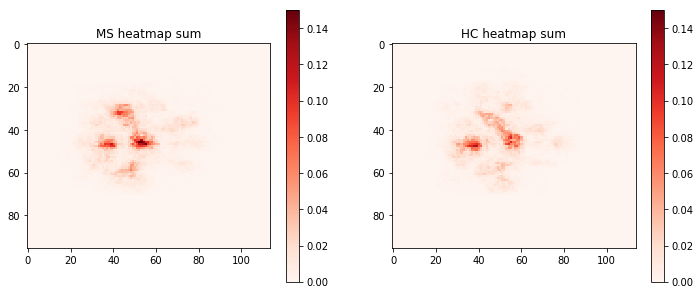

In [208]:
plt.figure(figsize=(12, 5))
vmin = np.min(np.squeeze(ms_heatmaps)[:,:,sl])
vmax = np.max(np.squeeze(ms_heatmaps)[:,:,sl])
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(ms_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("MS heatmap sum")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(hc_heatmaps)[:,:,sl], cmap='Reds', vmin=vmin, vmax=vmax)
plt.title("HC heatmap sum")
plt.colorbar()
plt.show()

In [817]:
def replace_activations(model, activation=keras.activations.relu):
    for layer in model.layers:
        if isinstance(layer, keras.layers.Conv3D):
            layer.activation = activation
    return model

In [818]:
#model = replace_activations(model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

#beheaded_model = replace_activations(beheaded_model)
#opti = keras.optimizers.Adam(lr=0.0005, decay=0.002)
#beheaded_model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])

# Visualizing 4 subjects

### MS

In [90]:
# find subjects with highest sigmoid output
scores = []
for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    score = fine_tuned_model.predict(image)
    scores.append(score[0][0])
idx_list = np.argsort(-np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


#########
Index 6
Score 0.997566
#########
Index 14
Score 0.993686
#########
Index 9
Score 0.988017
#########
Index 8
Score 0.982245
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [1.] 
sigmoid score [0.99756634]
beheaded score 6.015938
analysis sum 6.790123


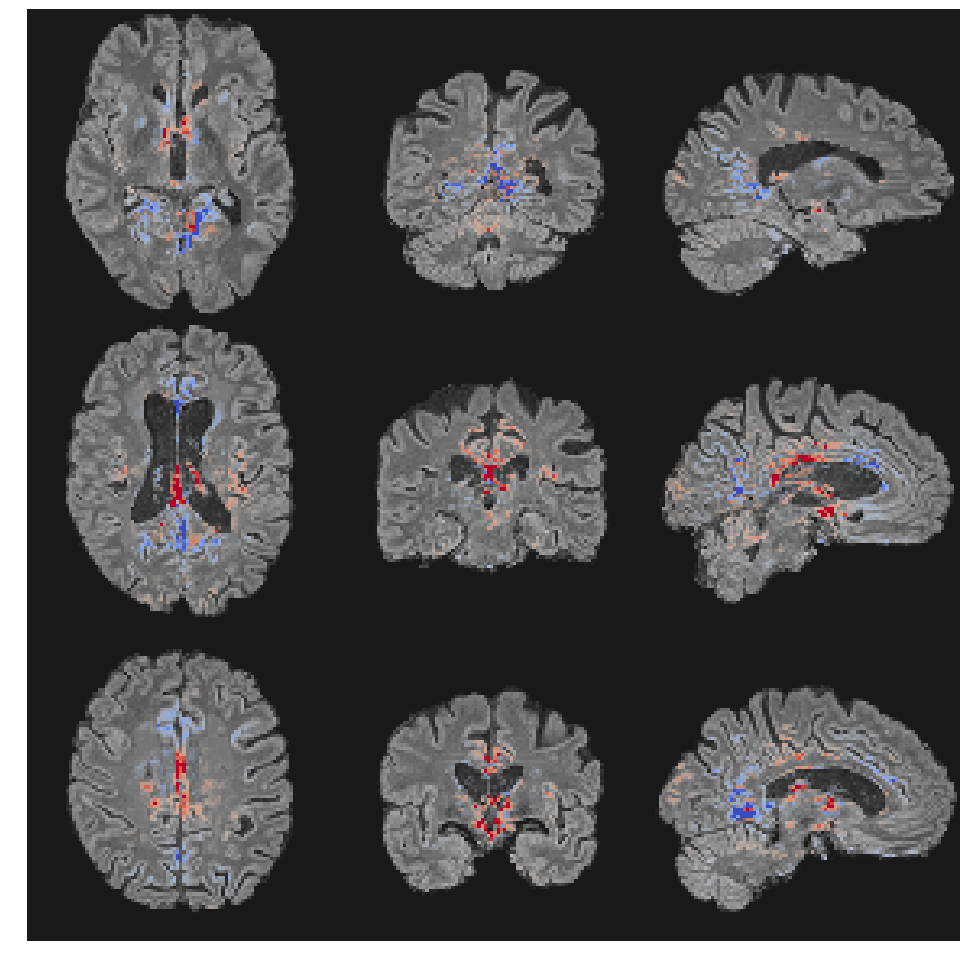

pred [1.] 
sigmoid score [0.99368566]
beheaded score 5.058598
analysis sum 6.315406


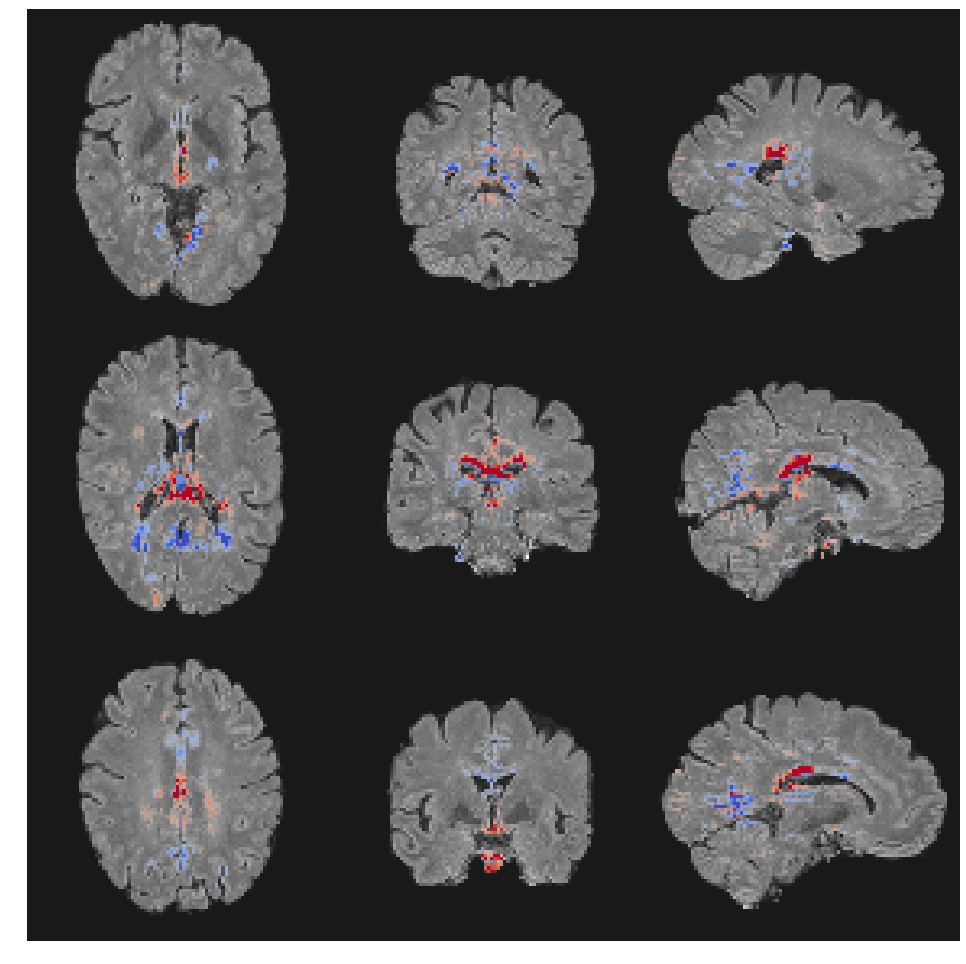

pred [1.] 
sigmoid score [0.9880172]
beheaded score 4.412232
analysis sum 5.943927


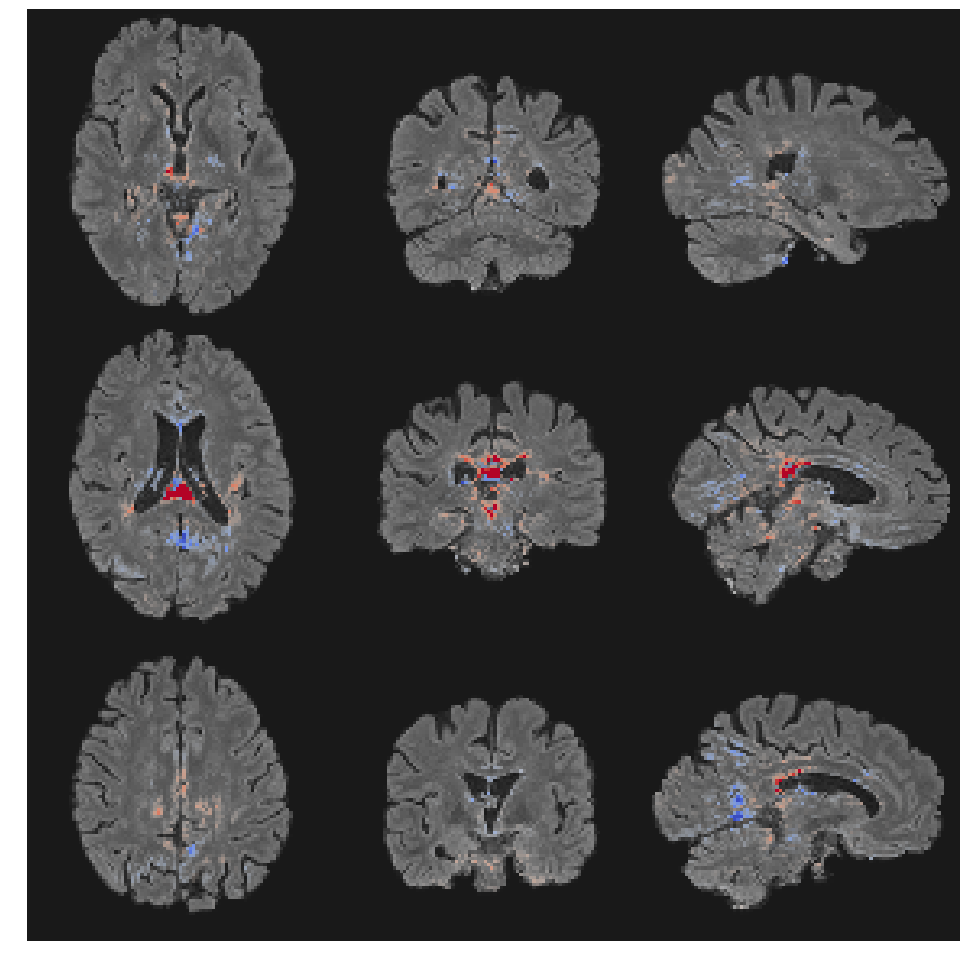

pred [1.] 
sigmoid score [0.9822448]
beheaded score 4.013162
analysis sum 4.691539


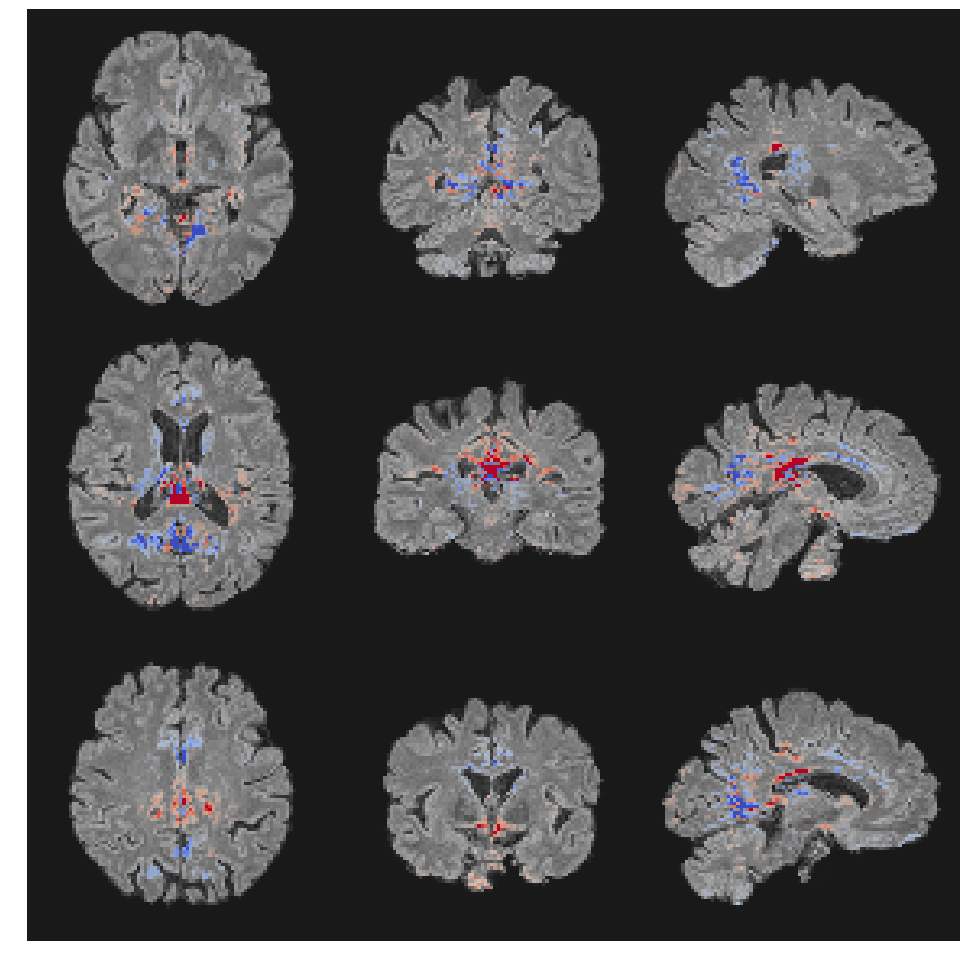

In [91]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "MS_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

### Healthy controls

In [92]:
# get the lowest scores i.e. best classification for HC
idx_list = np.argsort(np.array(scores))[:4]

print("#########")
for idx in idx_list:
    print("Index %i" %idx)
    print("Score %f" % scores[idx])
    print("#########")

#########
Index 19
Score 0.058719
#########
Index 17
Score 0.117632
#########
Index 2
Score 0.158136
#########
Index 3
Score 0.210653
#########


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [0.] 
sigmoid score [0.0587195]
beheaded score -2.774469
analysis sum -3.918020


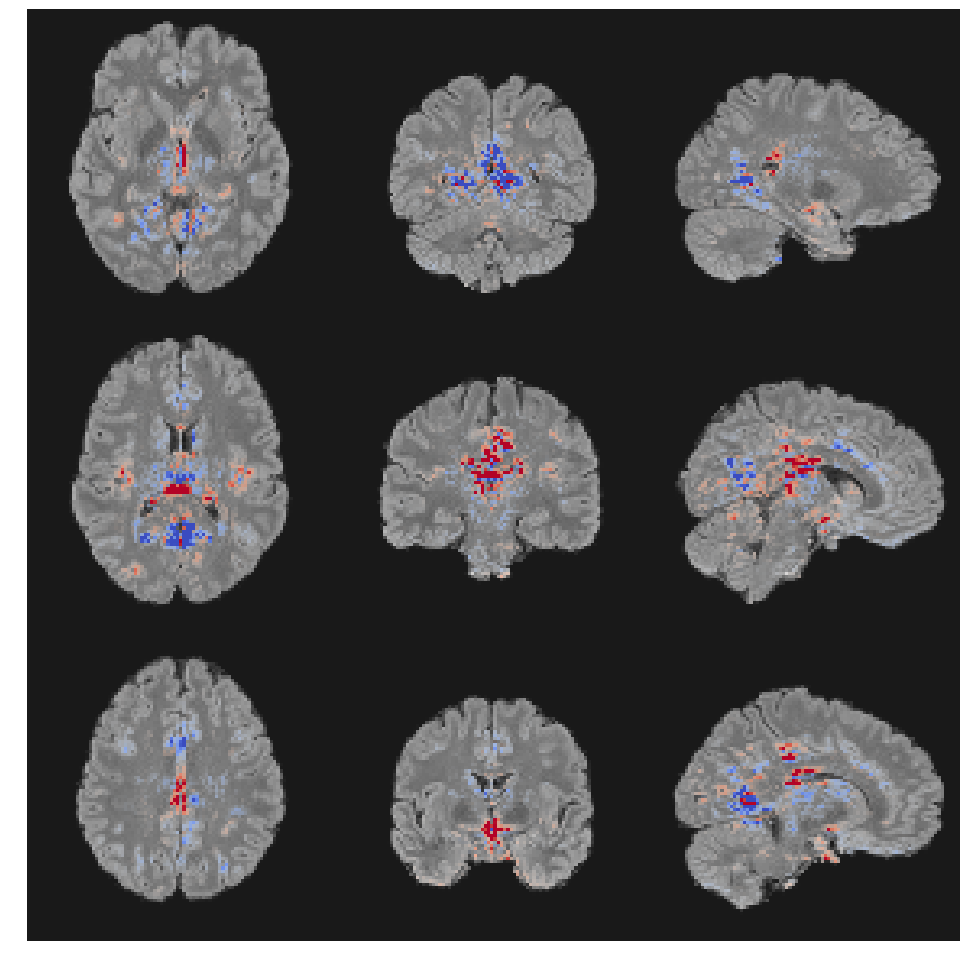

pred [0.] 
sigmoid score [0.11763228]
beheaded score -2.015045
analysis sum -3.072939


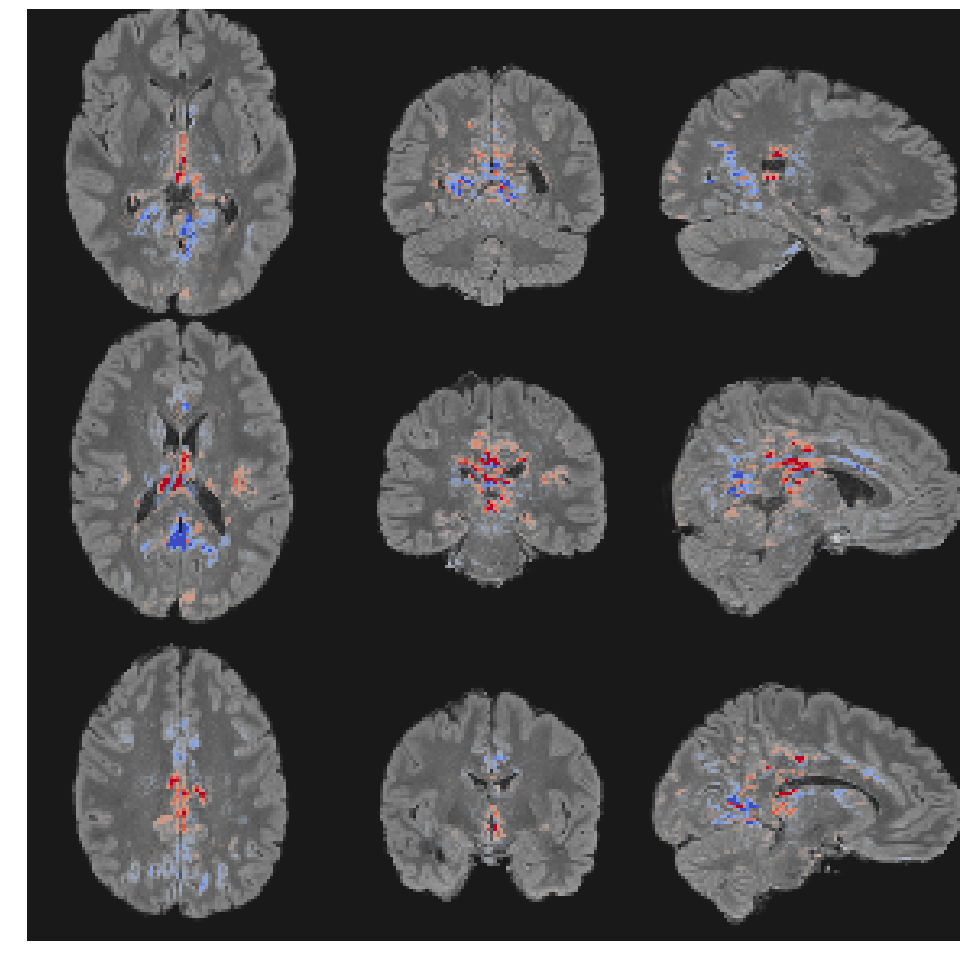

pred [0.] 
sigmoid score [0.15813634]
beheaded score -1.672161
analysis sum -1.872295


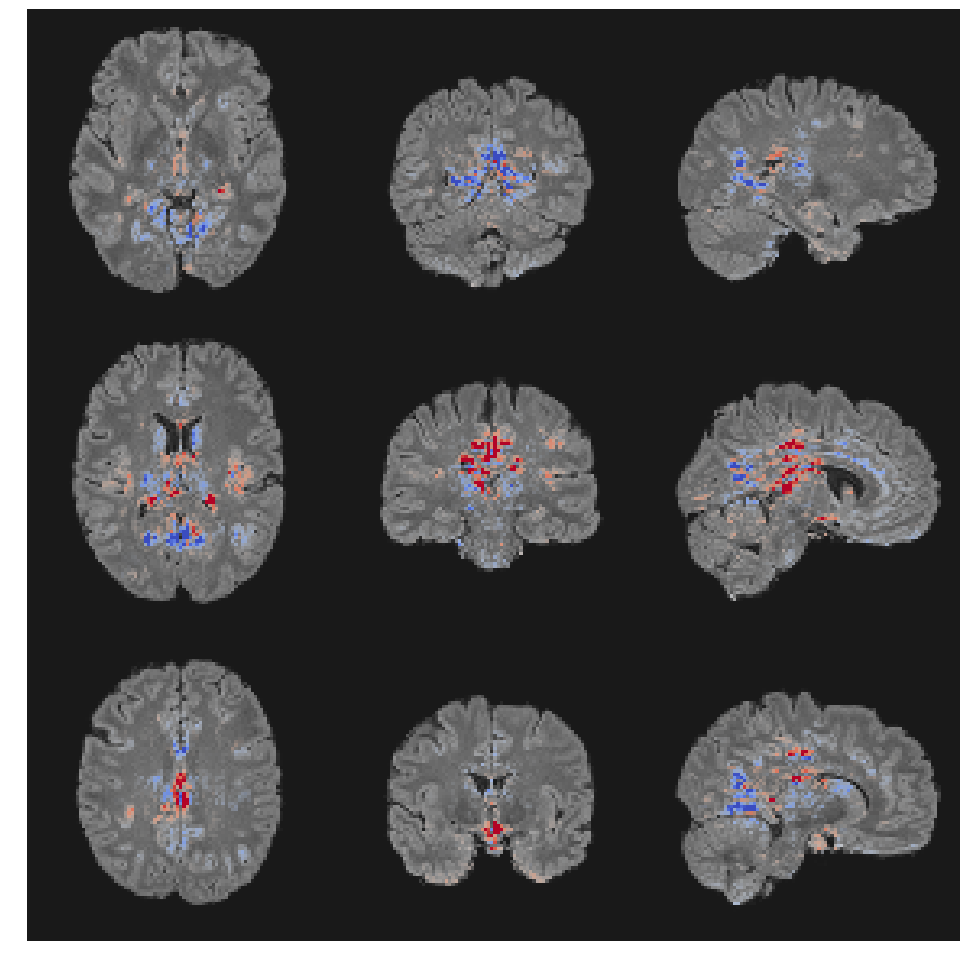

pred [0.] 
sigmoid score [0.21065322]
beheaded score -1.320992
analysis sum -1.251004


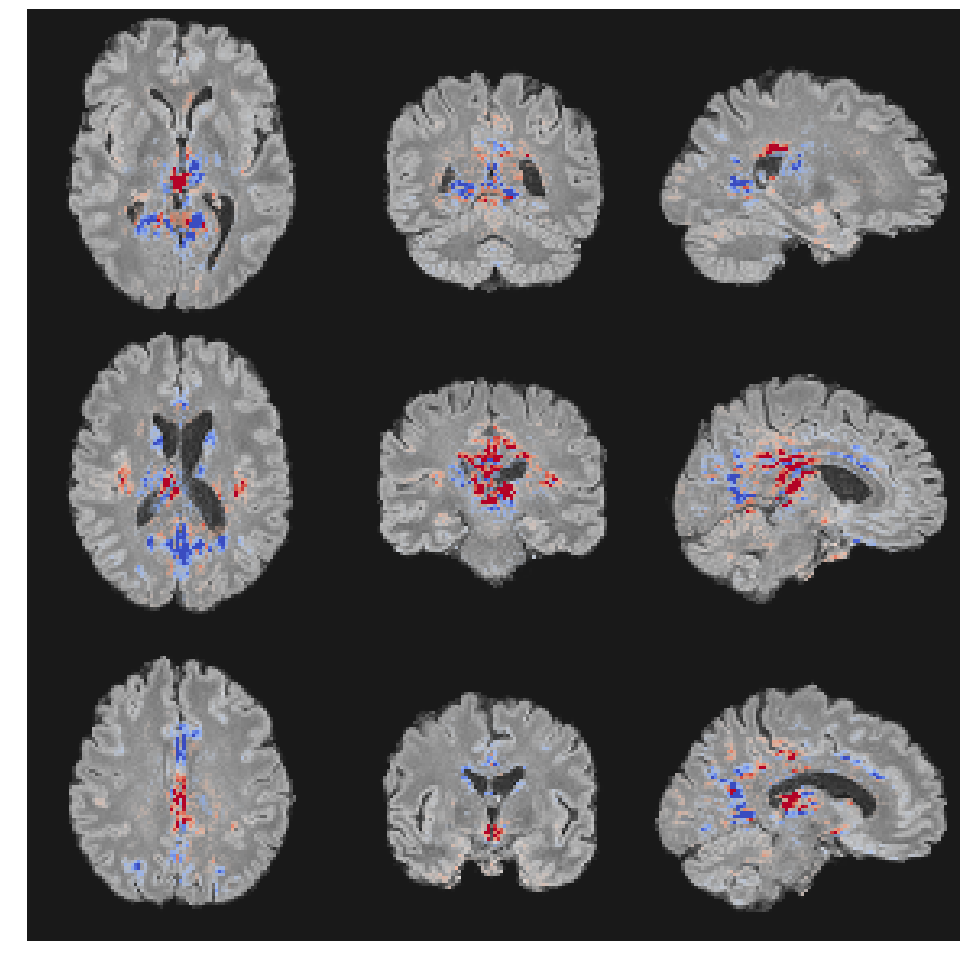

In [93]:
# Creating an analyzer
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", beheaded_model)
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)

#image_idx = 6 # very high correct sigmoid score

# idx list defined above
for image_idx in idx_list:
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]

    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))

    #a = list(range(15, 80, 5)) # full
    #b = list(range(16, 114, 8)) # full
    a = list(range(39, 56, 8)) # central slices
    b = list(range(40, 76, 12)) # central slices
    c = list(range(36, 56, 8)) # central slices

    #a = list(range(15, 80, 20)) # debug variant
    #b = list(range(16, 114, 24)) # debug variant
    show_cb = False
    sl = zip(a, b, c)
    fp = None
    #fp = os.path.join(image_file_dir, "HC_holdout_idx_{}_LRP_epsilon_0-001_central_slices.png".format(str(image_idx)))
    plot_heatmap2(analysis, image, vmin, vmax, title=str(label), cmap='TransCoWa',
                  sl=sl, show_average=False, show_colorbar=show_cb, file_path=fp)

# Visualizing all holdout scans

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


pred [1.] 
sigmoid score [0.54640055]
fine_tuned_beheaded score 0.186138
analysis sum 0.140147


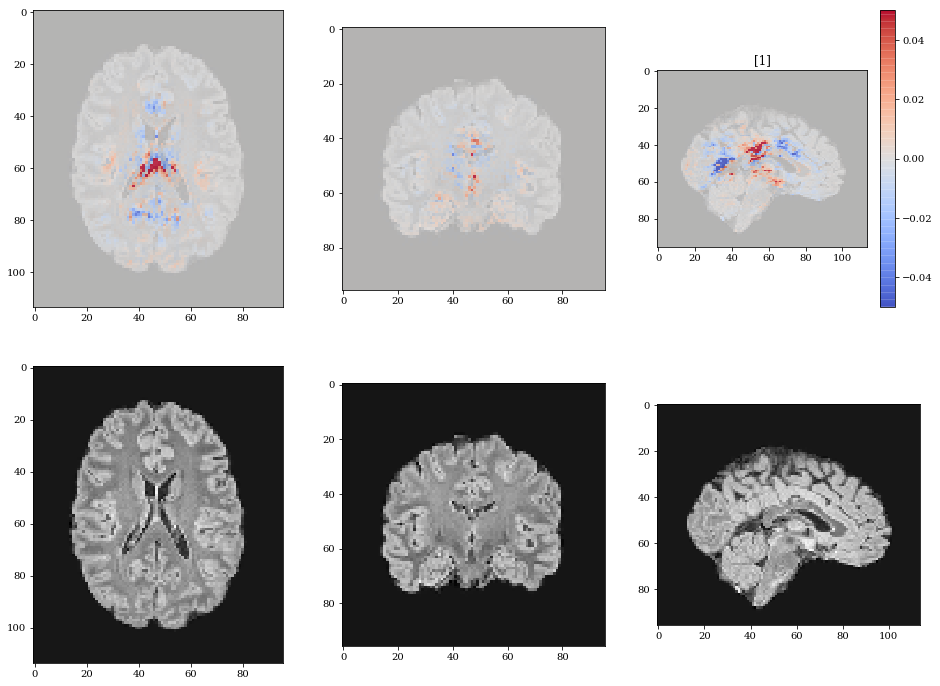

pred [1.] 
sigmoid score [0.8245245]
fine_tuned_beheaded score 1.547308
analysis sum 1.222176


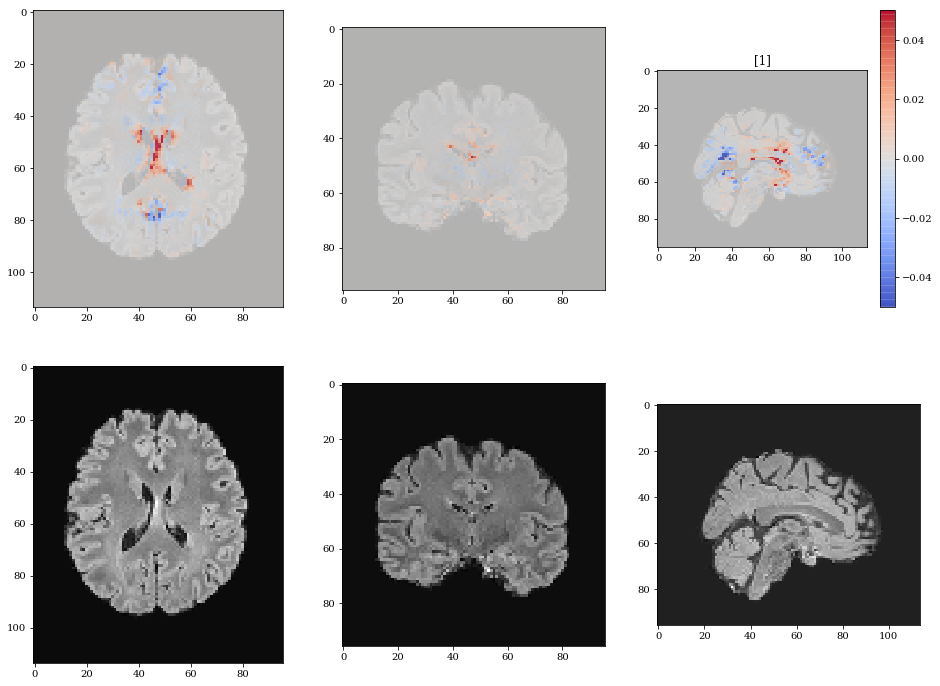

pred [0.] 
sigmoid score [0.15813634]
fine_tuned_beheaded score -1.672161
analysis sum -1.872295


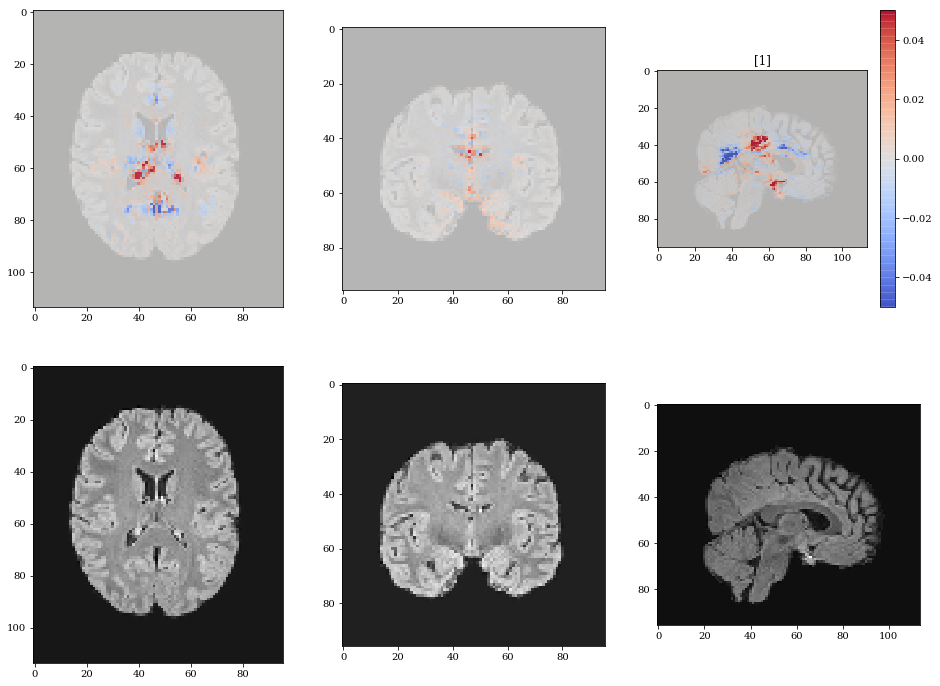

pred [0.] 
sigmoid score [0.21065322]
fine_tuned_beheaded score -1.320992
analysis sum -1.251002


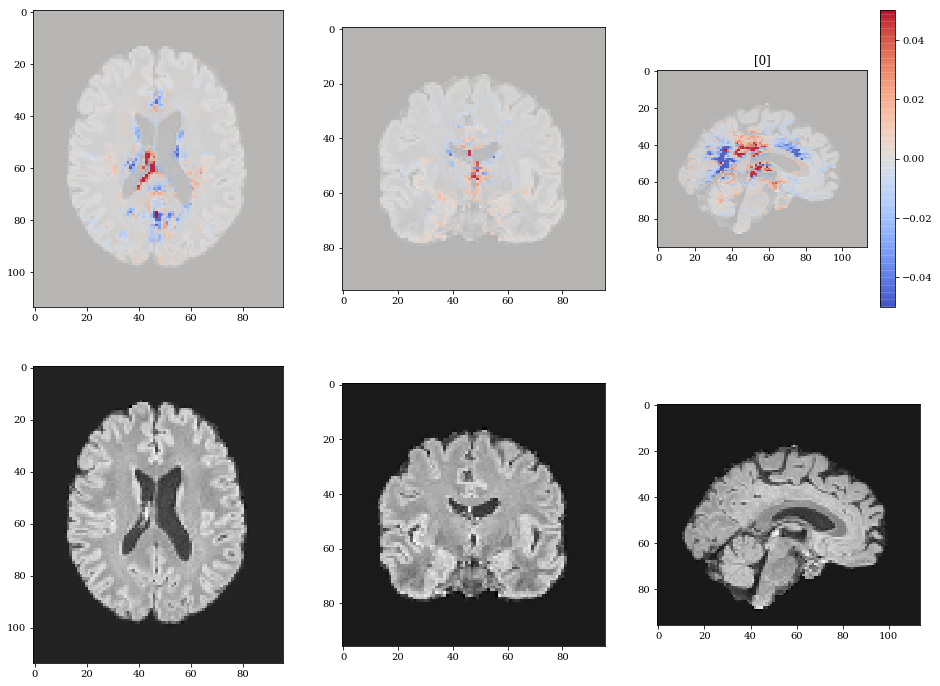

pred [1.] 
sigmoid score [0.9788138]
fine_tuned_beheaded score 3.832996
analysis sum 4.119129


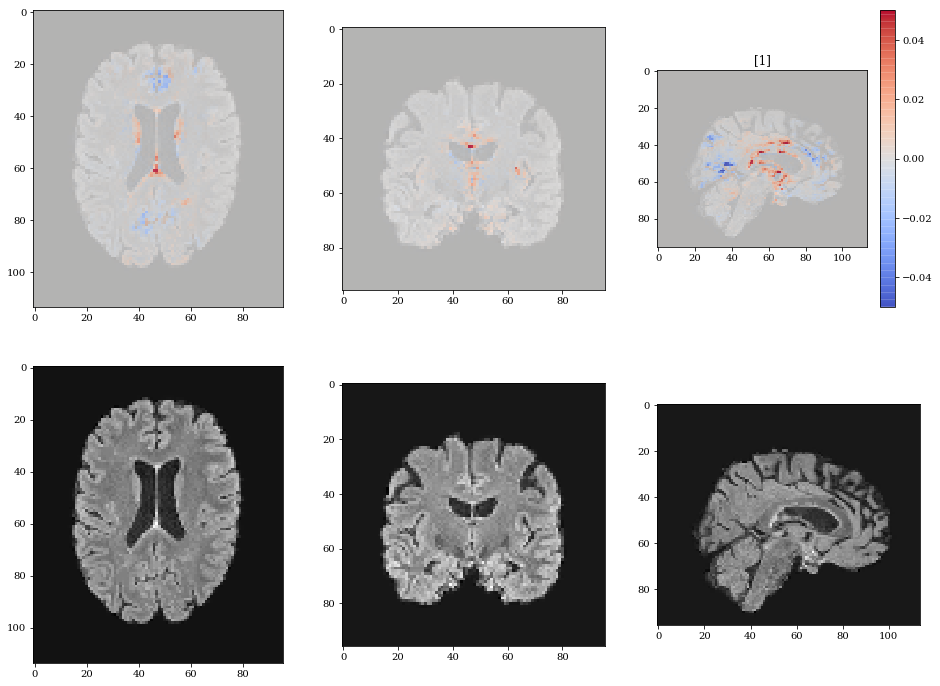

pred [1.] 
sigmoid score [0.64586926]
fine_tuned_beheaded score 0.600931
analysis sum 1.179171


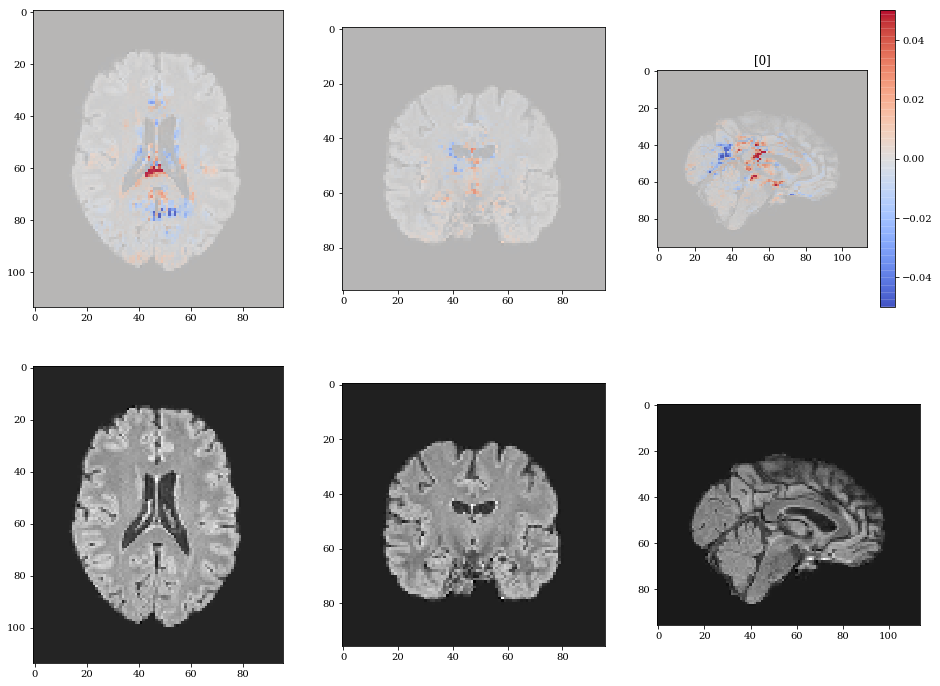

pred [1.] 
sigmoid score [0.99756634]
fine_tuned_beheaded score 6.015938
analysis sum 6.790121


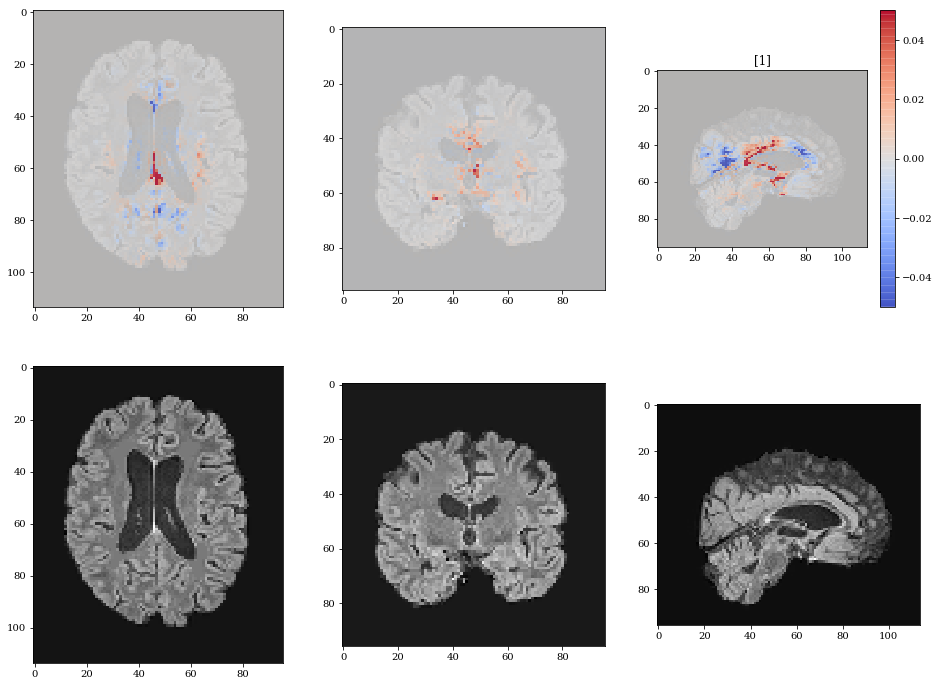

pred [1.] 
sigmoid score [0.61704916]
fine_tuned_beheaded score 0.477042
analysis sum 0.495029


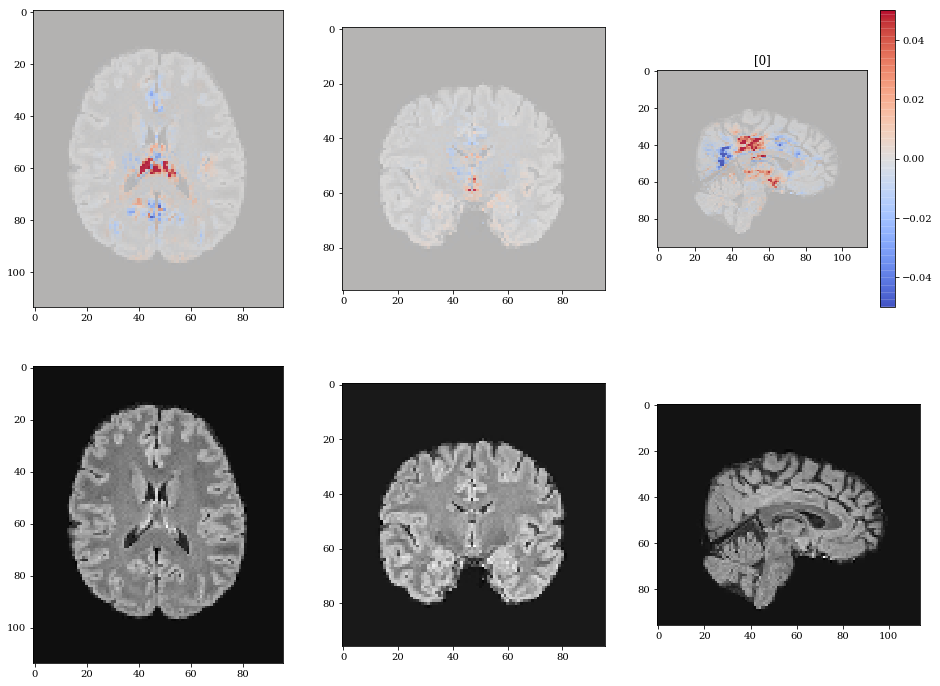

pred [1.] 
sigmoid score [0.9822448]
fine_tuned_beheaded score 4.013162
analysis sum 4.691537


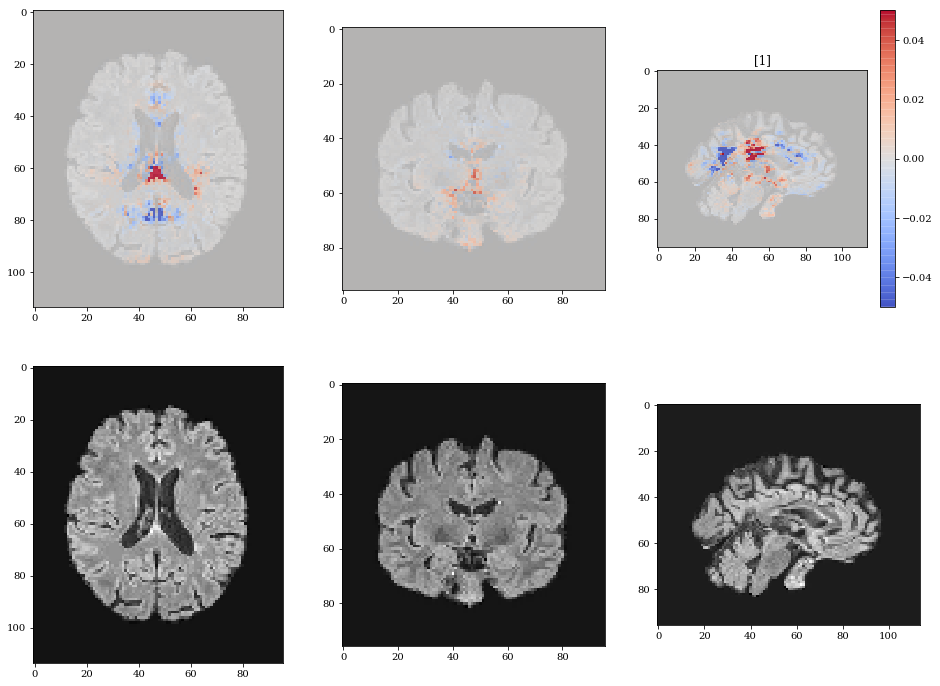

pred [1.] 
sigmoid score [0.9880172]
fine_tuned_beheaded score 4.412232
analysis sum 5.943929


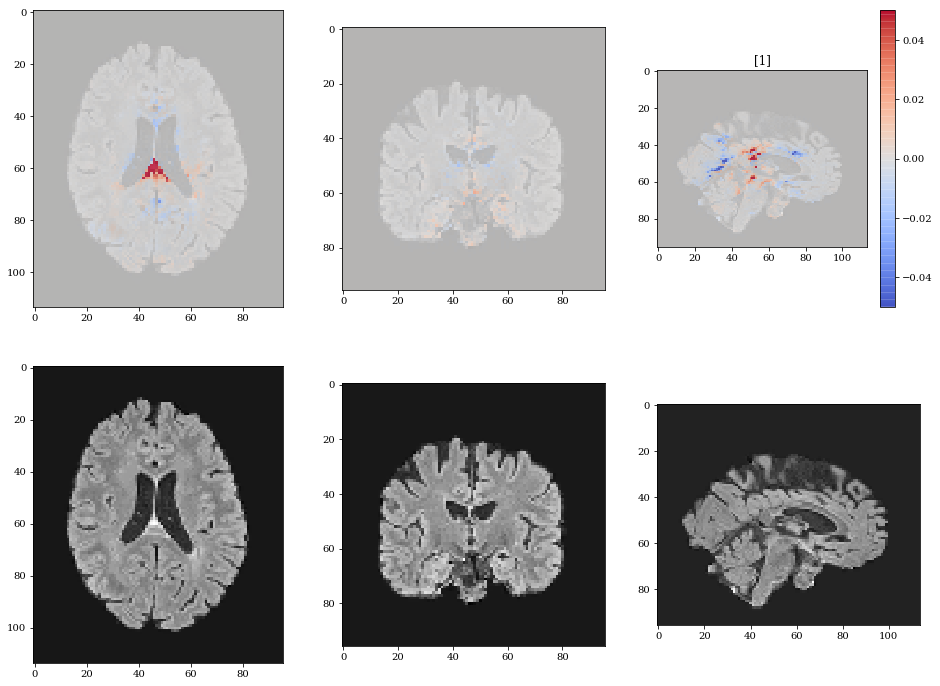

pred [0.] 
sigmoid score [0.24442753]
fine_tuned_beheaded score -1.128557
analysis sum -1.502881


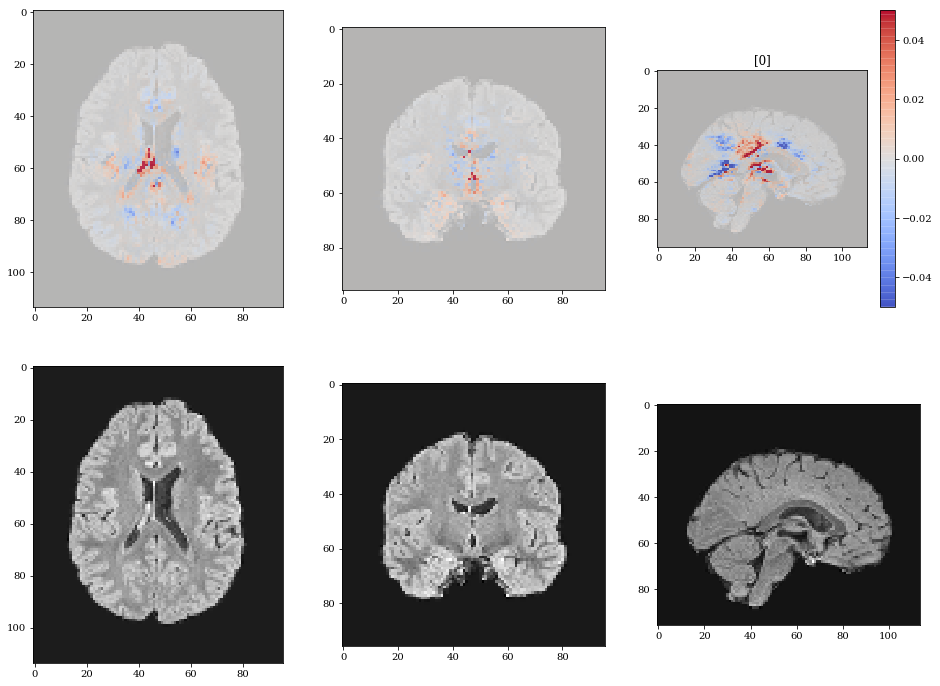

pred [1.] 
sigmoid score [0.8844019]
fine_tuned_beheaded score 2.034792
analysis sum 2.484122


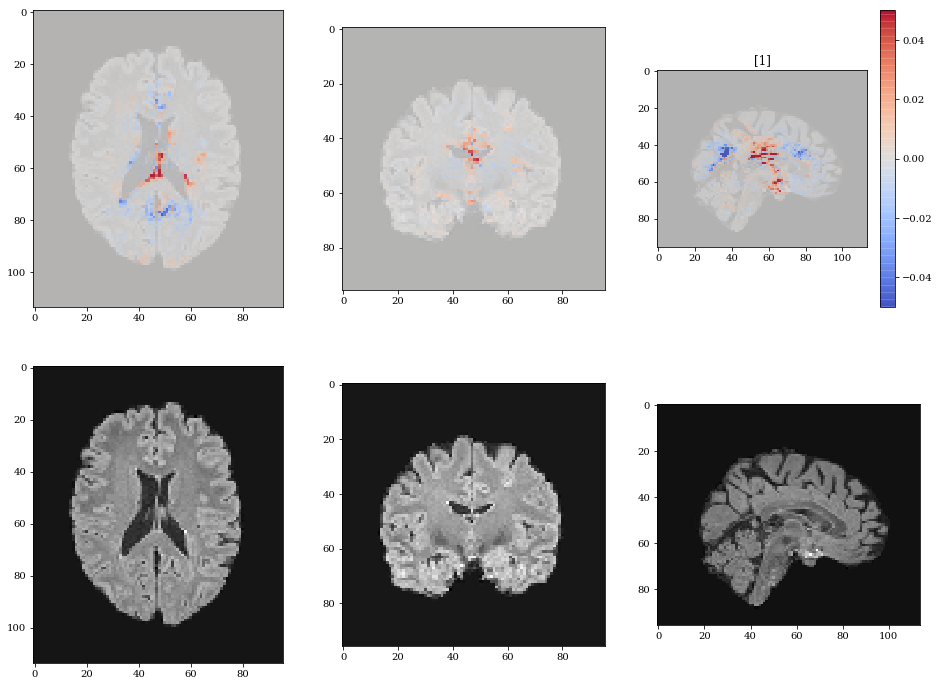

pred [1.] 
sigmoid score [0.8407121]
fine_tuned_beheaded score 1.663535
analysis sum 0.930162


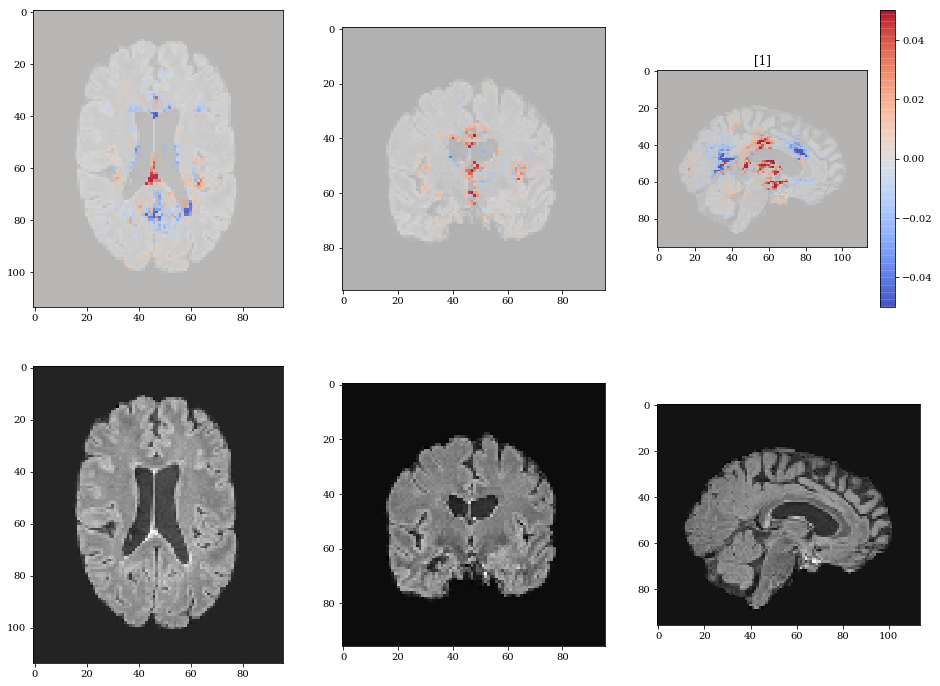

pred [1.] 
sigmoid score [0.9795689]
fine_tuned_beheaded score 3.870056
analysis sum 4.646037


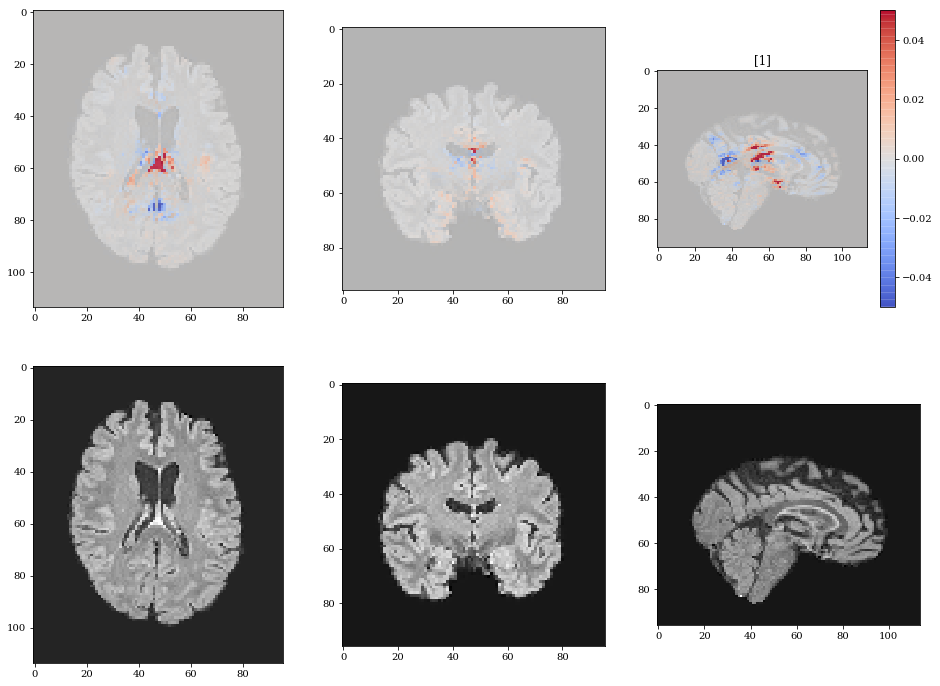

pred [1.] 
sigmoid score [0.99368566]
fine_tuned_beheaded score 5.058598
analysis sum 6.315403


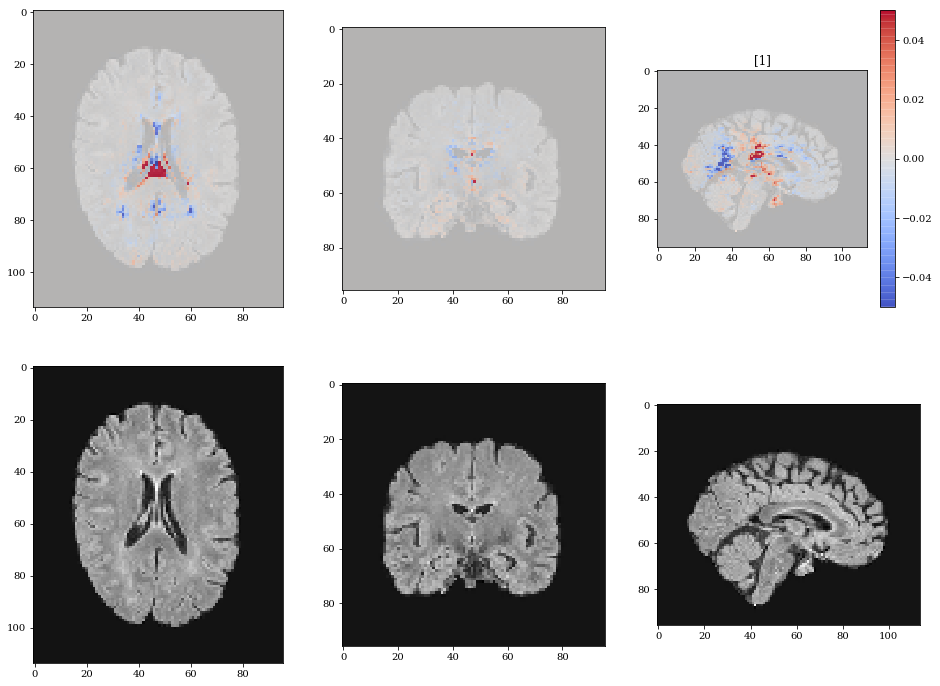

pred [0.] 
sigmoid score [0.36398005]
fine_tuned_beheaded score -0.558131
analysis sum -0.346196


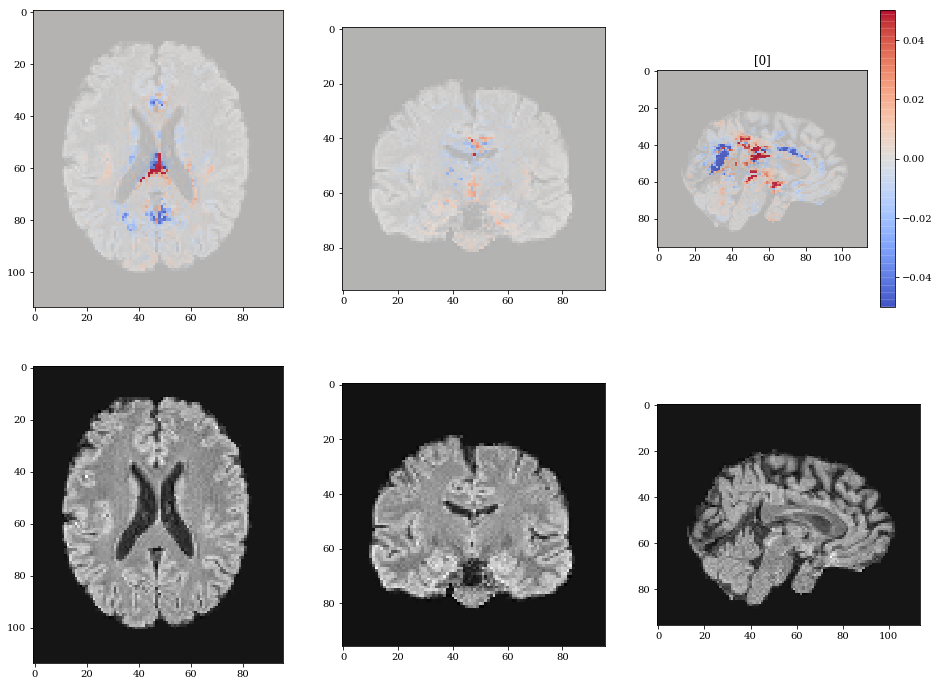

pred [1.] 
sigmoid score [0.7571461]
fine_tuned_beheaded score 1.137096
analysis sum 1.957239


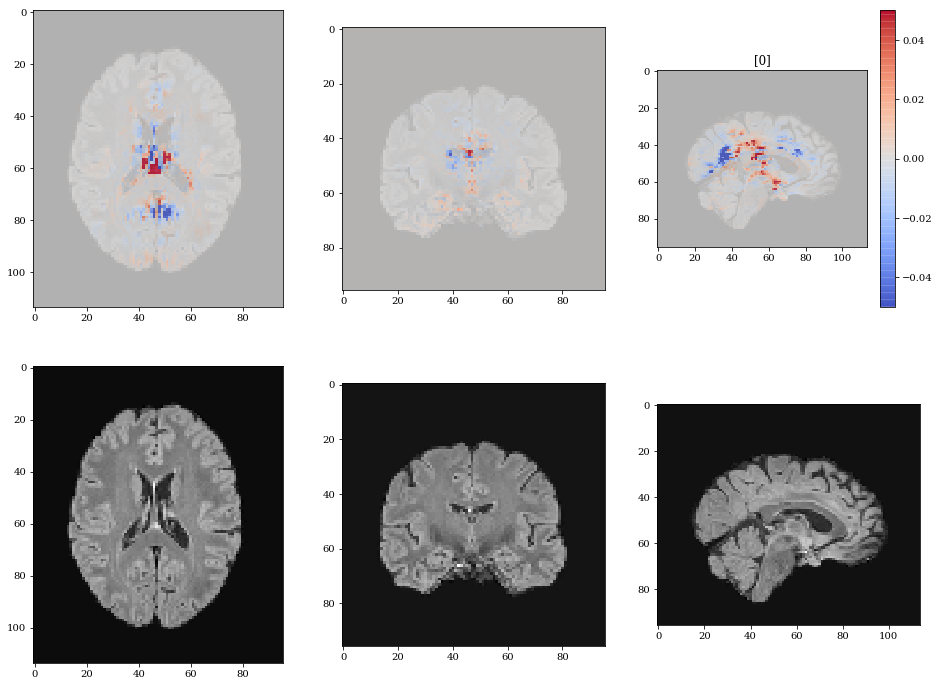

pred [0.] 
sigmoid score [0.11763228]
fine_tuned_beheaded score -2.015045
analysis sum -3.072938


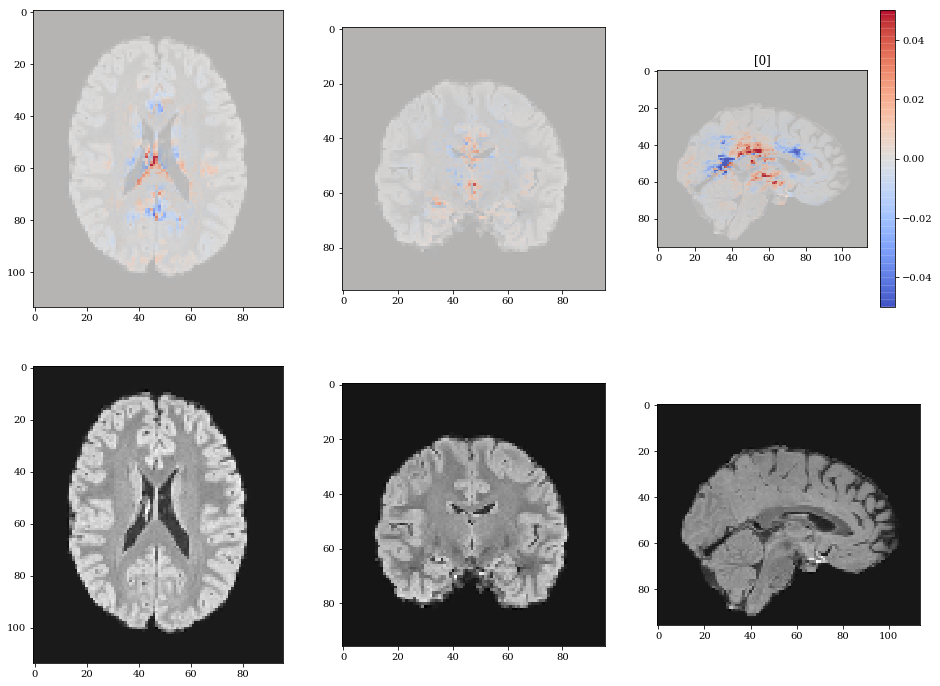

pred [1.] 
sigmoid score [0.8139332]
fine_tuned_beheaded score 1.475772
analysis sum 1.103190


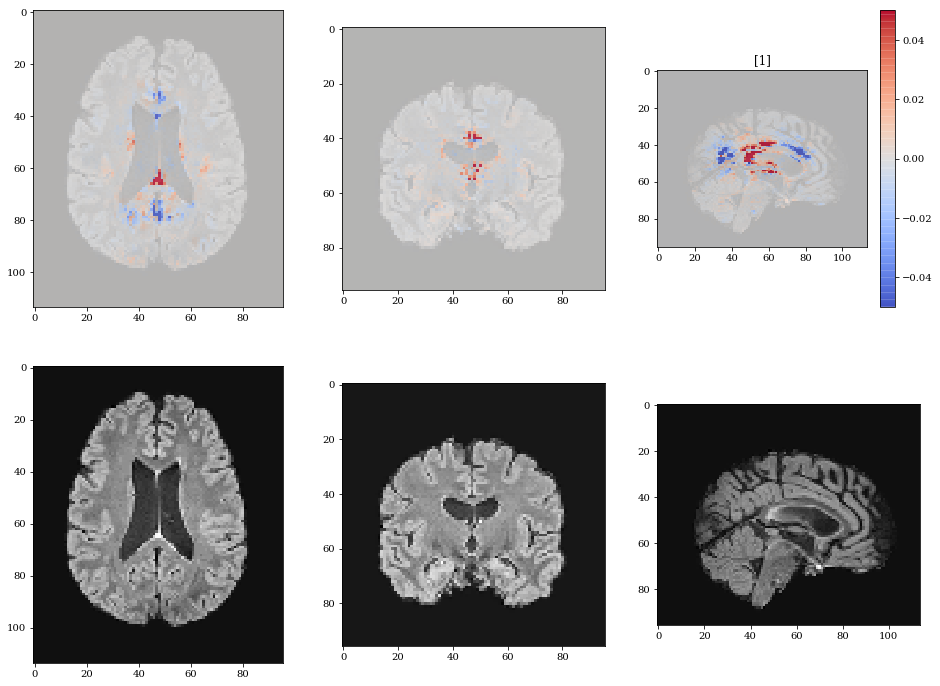

pred [0.] 
sigmoid score [0.0587195]
fine_tuned_beheaded score -2.774469
analysis sum -3.918020


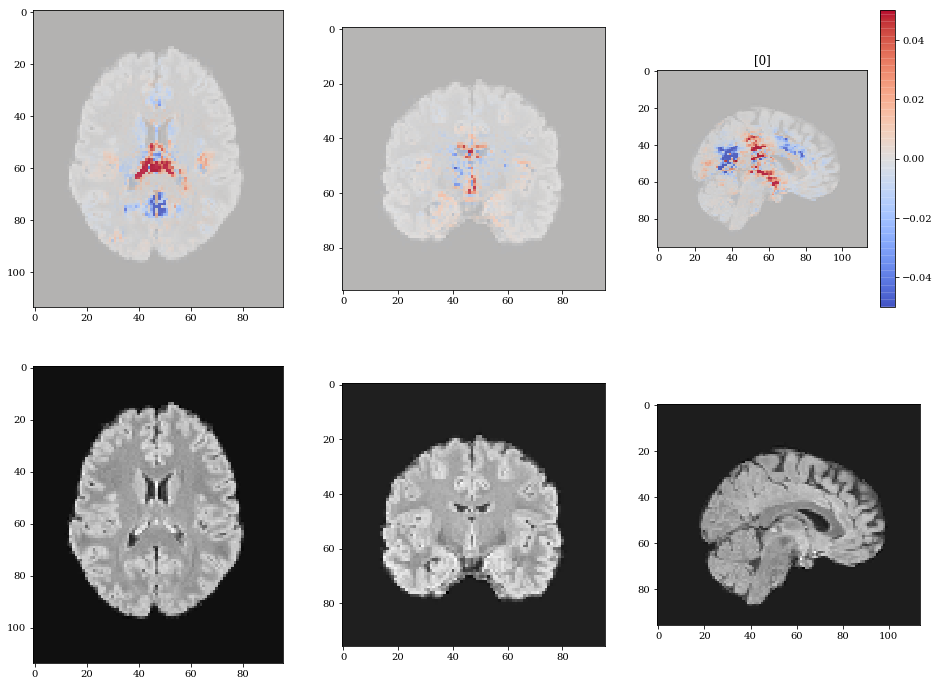

pred [0.] 
sigmoid score [0.40243185]
fine_tuned_beheaded score -0.395343
analysis sum -1.789769


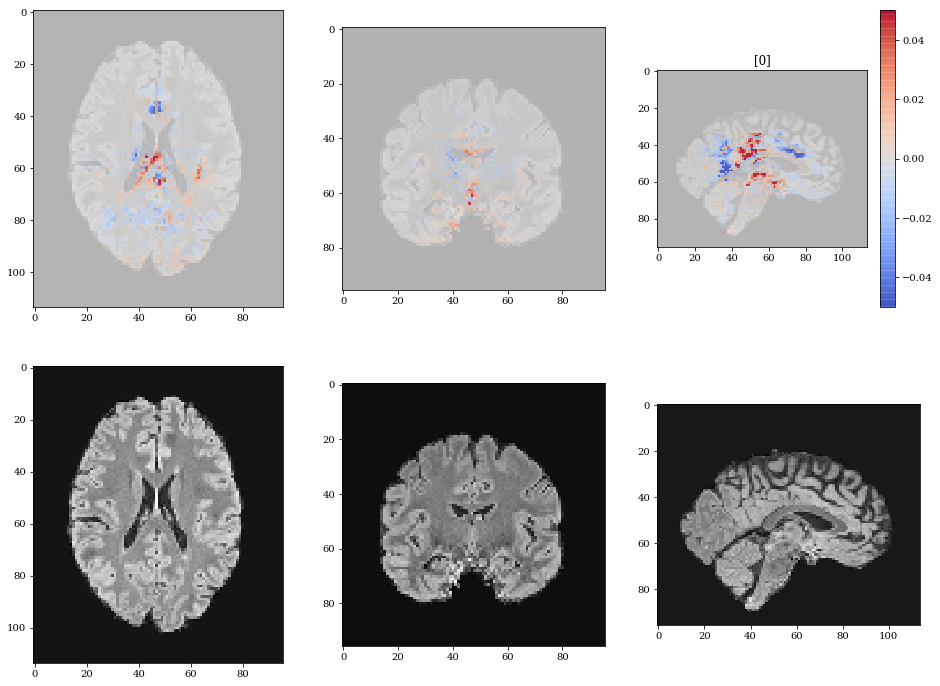

pred [1.] 
sigmoid score [0.73451024]
fine_tuned_beheaded score 1.017628
analysis sum 1.579785


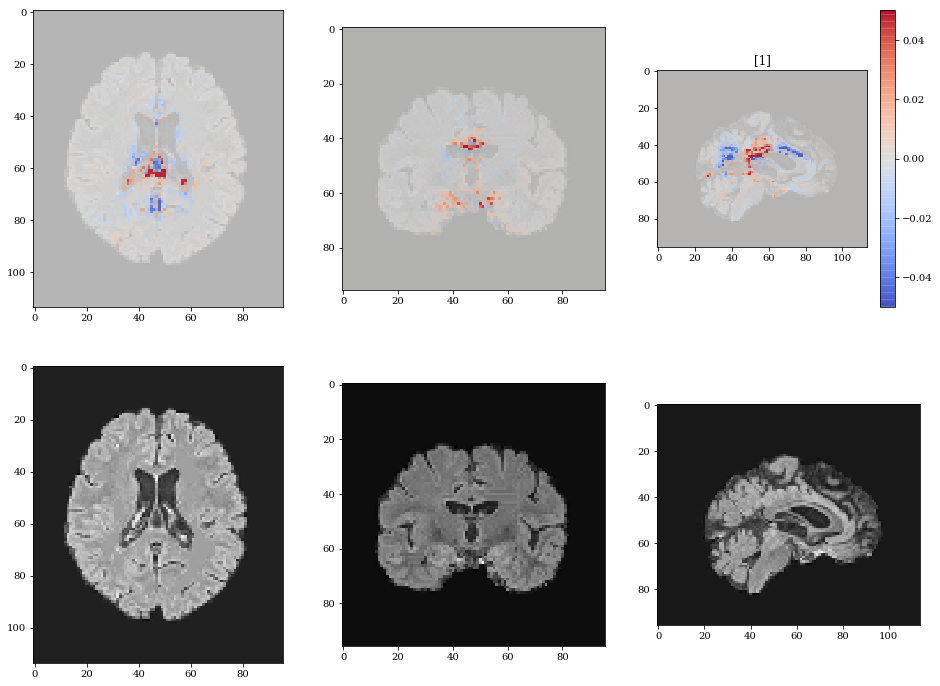

pred [0.] 
sigmoid score [0.38222057]
fine_tuned_beheaded score -0.480134
analysis sum -0.076657


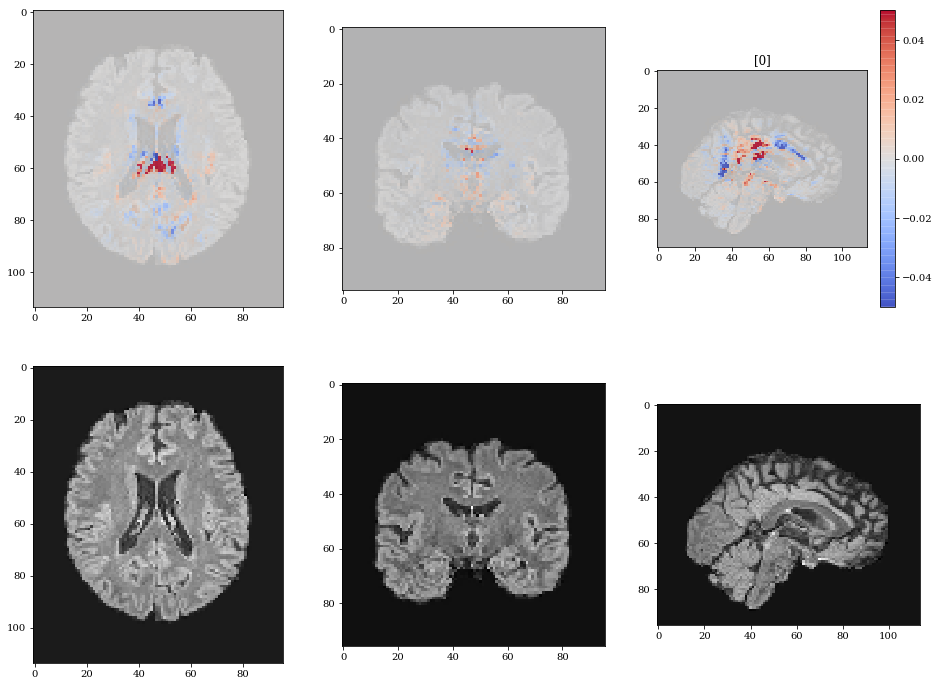

In [94]:
# Creating an analyzer
gradient_analyzer = innvestigate.create_analyzer("lrp.epsilon", fine_tuned_beheaded_model, epsilon=0.001)
#gradient_analyzer = innvestigate.create_analyzer("lrp.z", fine_tuned_beheaded_model)

for image_idx in range(len(test_loader)):
    image = test_loader[image_idx][0][[0]]
    label = test_loader[image_idx][1][[0]]
    # Get predictions
    be_score = fine_tuned_beheaded_model.predict(image)
    score = fine_tuned_model.predict(image)
    pred = (score > 0.5) * 1.

    # Applying the analyzer
    analysis = gradient_analyzer.analyze(image)
    print("pred %s " % pred[0])
    print("sigmoid score %s" % score[0])
    print("fine_tuned_beheaded score %f" % be_score[0])
    print("analysis sum %f" % np.sum(analysis))
    plot_heatmap(analysis, image, vmin, vmax, title=str(label), cmap='coolwarm')

# Averages pre-training vs scratch comparison

In [95]:
pre_trained_TP_heatmaps_holdout, pre_trained_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 0
zero 10


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


In [96]:
pre_trained_TP_heatmaps_train, pre_trained_TN_heatmaps_train = get_heatmap_sum(train_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 120
one 0
zero 59


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


In [97]:
fine_tuned_TP_heatmaps_holdout, fine_tuned_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 7


In [98]:
pre_trained_MS_heatmaps_holdout, pre_trained_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=pre_trained_beheaded_model, prediction_model=pre_trained_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [99]:
fine_tuned_MS_heatmaps_holdout, fine_tuned_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=fine_tuned_beheaded_model, prediction_model=fine_tuned_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [100]:
scratch_TP_heatmaps_holdout, scratch_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 12
zero 6


In [101]:
scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=scratch_beheaded_model, prediction_model=scratch_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [102]:
random_TP_heatmaps_holdout, random_TN_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='prediction')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by prediction
total 23
one 11
zero 2


In [103]:
random_MS_heatmaps_holdout, random_HC_heatmaps_holdout = get_heatmap_sum(test_loader, ((1,) + shape + (1,)), beheaded_model=random_beheaded_model, prediction_model=random_model, mode='label')

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Sorted by label
total 23
one 13
zero 10


In [104]:
def plot_heatmap_transfer_learning(heatmaps, scan_avg, vmin=-0.05, vmax=0.05, title=None, cmap='seismic', show_average=True, show_colorbar=False, file_path=None):
    """ 
    Plot heatmaps of averages for class zero and class one.
    Iterate over heatmaps rather than slices.
    """
    
    sl = (48, 60, 48)
    nrows = len(heatmaps)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13., 5 * nrows), # settings for whole subject
                             gridspec_kw = {'wspace':0, 'hspace':0.15})
    
    for ax in axes.ravel():
        ax.axis('off')
    if nrows == 1:
        axes = [axes]
    
    for count, heatmap in enumerate(heatmaps):
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(scan_avg)[:,9:105,sl[0]], axes=(0, 1)), cmap='gray')
        im1 = axes[count][0].imshow(np.rot90(np.squeeze(heatmap)[:,9:105,sl[0]], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
            
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        im2 = axes[count][1].imshow(np.rot90(np.squeeze(heatmap)[:,sl[1],:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)
        if title is not None:
            axes[count][1].set_title(title[count], fontsize=16, y=1.03)
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(scan_avg)[sl[2],9:105,:], axes=(0, 1)), cmap='gray')
        im3 = axes[count][2].imshow(np.rot90(np.squeeze(heatmap)[sl[2],9:105,:], axes=(0, 1)), cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

    if show_average:
        plt.subplot(2, 3, 4)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,:,sl[0]], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 5)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[:,sl[1],:], axes=(0, 1)), cmap='gray')
        plt.subplot(2, 3, 6)
        plt.imshow(np.rot90(np.squeeze(scan_avg)[sl[2],:,:], axes=(0, 1)), cmap='gray')
    
    if show_colorbar:
        p1 = axes[count][0].get_position().get_points().flatten()
        p2 = axes[count][1].get_position().get_points().flatten()
        p3 = axes[count][2].get_position().get_points().flatten()
        
        # position of the colorbar: left, bottom, width, height
        # in relevance to the entire figure size
        cax = fig.add_axes([p1[0]+0.08, 0.085, p2[2], 0.015]) # settings for average
        cbar = fig.colorbar(im2, cax=cax, ticks=[vmin, 0, vmax], orientation="horizontal")
        cbar.ax.set_xticklabels(['Negative Relevance', 'No Relevance', 'Positive Relevance'], fontsize=14)
        
    
    # ensure colorbar is within plot
    #fig.subplots_adjust(bottom=0.2)
    # move everthing closely
    plt.tight_layout()
    
    if file_path is not None:
        plt.savefig(file_path, format='png', transparent=True, bbox_inches='tight')
    plt.show()

/home/fabiane/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


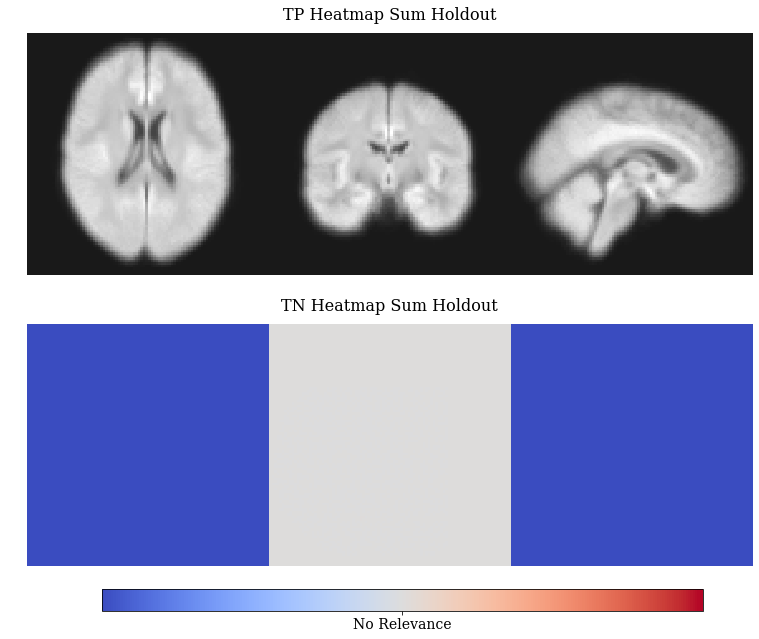

In [105]:
hms = [pre_trained_TP_heatmaps_holdout, pre_trained_TN_heatmaps_holdout]
titles = ["TP Heatmap Sum Holdout", "TN Heatmap Sum Holdout"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
plot_heatmap_zero_one(hms, avg_train_image, vmin=np.min(pre_trained_TP_heatmaps_holdout), vmax=np.max(pre_trained_TP_heatmaps_holdout), 
                  cmap='coolwarm', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

In [106]:
image_file_dir

'/analysis/fabiane/documents/publications/MS_CNN_VIS'

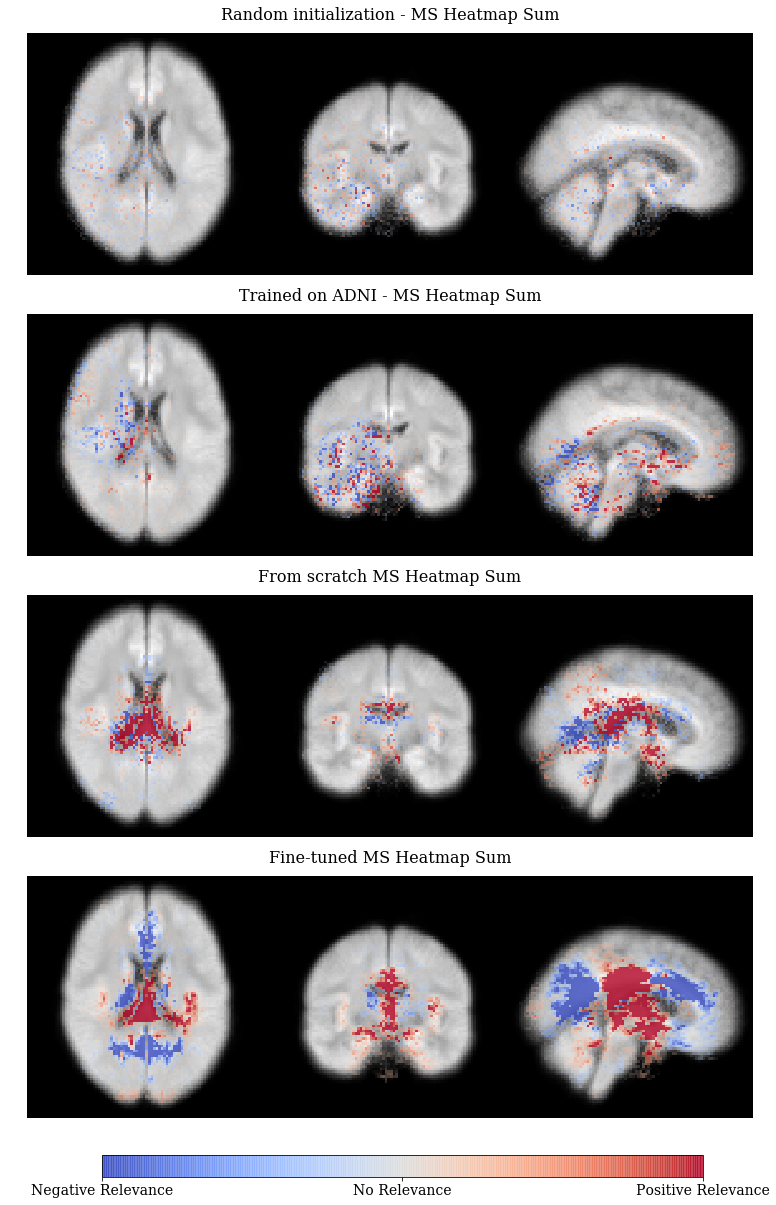

In [107]:
hms = [random_MS_heatmaps_holdout * 20, pre_trained_MS_heatmaps_holdout * 20, scratch_MS_heatmaps_holdout, fine_tuned_MS_heatmaps_holdout]
titles = ["Random initialization - MS Heatmap Sum", "Trained on ADNI - MS Heatmap Sum", "From scratch MS Heatmap Sum", "Fine-tuned MS Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_TransferLearning_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout * 15)
vmax = -vmin
#vmin = None
#vmax = None
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

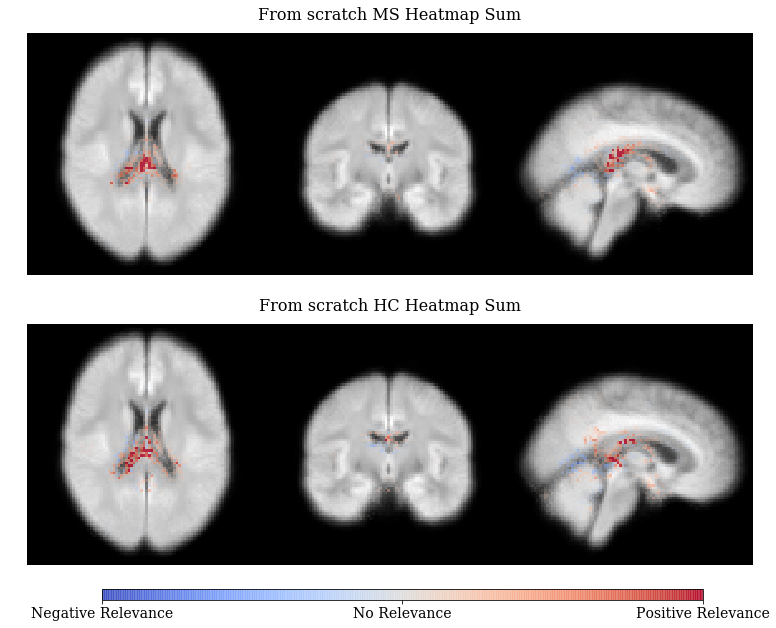

In [108]:
hms = [scratch_MS_heatmaps_holdout, scratch_HC_heatmaps_holdout]
titles = ["From scratch MS Heatmap Sum", "From scratch HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(scratch_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

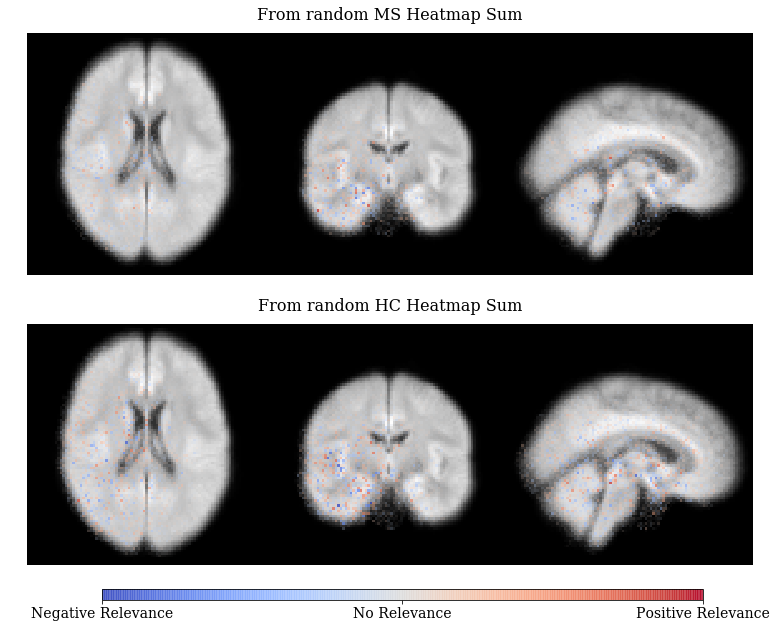

In [109]:
hms = [random_MS_heatmaps_holdout, random_HC_heatmaps_holdout]
titles = ["From random MS Heatmap Sum", "From random HC Heatmap Sum"]
show_cb = True
#fp = os.path.join(image_file_dir, "average_holdout_MS_HC_coolwarm_serif.png")
fp = None
vmin = np.min(random_MS_heatmaps_holdout)
vmax = -vmin
plot_heatmap_transfer_learning(hms, avg_train_image, vmin=vmin, vmax=vmax, 
                  cmap='TransCoWa', show_average=False, show_colorbar=show_cb,
                  title=titles, file_path=fp)

## Correlations

In [110]:
def remove_nans_from_two_lists(former, latter, base="latter"):
    """ Remove nans from two arrays according to selected. """
    if base == "latter":
        slave = np.copy(former)
        master = np.copy(latter)
    elif base == "former":
        slave = np.copy(latter)
        master = np.copy(former)
    else:
        raise("Specify base as 'former' or 'latter'")
    
    not_nan_locs = np.where(~np.isnan(master))[0]
    print(len(not_nan_locs))
    master = master[~np.isnan(master)]
    slave = slave[not_nan_locs]
    
    if base == "latter":
        return slave, master
    elif base == "former":
        return master, slave

In [111]:
def heatmap_lesion_similarity_sign(heatmap, lesions, sign="positive", plot=False):
    assert(heatmap.shape == lesions.shape)
    hm = np.copy(heatmap)
    lm = np.copy(lesions)
    sl = 48
    
    # check for missing lesion masks which are filled randomly
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill with NaNs")
        #plt.imshow(lesions[:,:,sl], cmap='gray')
        #plt.title("Random filled mask")
        #plt.show()
        similarity = np.NaN
    else:
        if sign == "positive":
            hm[hm<0.] = 0
        elif sign == "negative":
            hm[hm>0.] = 0
        l = lm * hm
        similarity = np.sum(l)
    
    if plot:
        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(lesions[:,:,sl], cmap='gray')
        #plt.imshow(hm[:,:,sl], cmap='Reds', alpha=0.6)
        plt.title("Lesion Mask")
        plt.subplot(1,2,2)
        plt.imshow(hm[:,:,sl], cmap='Reds')
        plt.title("Signed Heatmap")
        plt.show()
    
    similarity /= np.sum(hm)
    
    return similarity

### Correlation between relevance/lesion amount and EDSS

In [3361]:
"""train_loader = CISDataset(X_train,
                         y_train,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None,
                         include_arbtr=True,
                         edss=np.array(edss_train)
                         )

test_loader = CISDataset(X_holdout,
                         y_holdout,
                         transform=[intensity],
                         batch_size=1,
                         shuffle=False,
                         z_factor=z_factor,
                         mask=None,
                         include_arbtr=True,
                         edss=np.array(edss_holdout)
                         )"""

In [3386]:
# Get heatmaps of all subjects
"""heatmap_list_holdout, edss_list_holdout = get_heatmap_list_with_edss(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
heatmap_list_train, edss_list_train = get_heatmap_list_with_edss(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
"""

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Make lists for comparisons

In [3420]:
"""training_sim = []
training_lesion_sum = []
training_score_list = []
training_pred_list = []
training_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_train):
    lesions = lesion_masks_train[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_train[idx])
    training_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        training_lesion_sum.append(np.NaN)
    else:
        training_lesion_sum.append(np.sum(lesion_masks_train[idx]))
    score = fine_tuned_model.predict(train_loader[idx][0]).item()
    training_score_list.append(score)
    pred = int(score>= 0.5)
    training_pred_list.append(pred)
    # check if correctly classified
    if pred == train_loader[idx][1].item():
        training_true_pred_list.append(1)
    else:
        training_true_pred_list.append(0)"""

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.


In [3426]:
"""holdout_sim = []
holdout_lesion_sum = []
holdout_score_list = []
holdout_pred_list = []
holdout_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_holdout):
    lesions = lesion_masks_holdout[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_holdout[idx])
    holdout_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        holdout_lesion_sum.append(np.NaN)
    else:
        holdout_lesion_sum.append(np.sum(lesion_masks_holdout[idx]))
    score = fine_tuned_model.predict(test_loader[idx][0]).item()
    holdout_score_list.append(score)
    pred = int(score >= 0.5)
    holdout_pred_list.append(pred)
    # check if correctly classified
    if pred == test_loader[idx][1].item():
        holdout_true_pred_list.appenfd(1)
    else:
        holdout_true_pred_list.append(0)"""

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3389]:
# remove healthy controls from EDSS table
#edss_train = np.array(edss_train)
#edss_holdout = np.array(edss_holdout)

#train_patient_loc = np.where(np.array(y_train) == 1)
#holdout_patient_loc = np.where(np.array(y_holdout) == 1)

#edss_train_MS = edss_train[train_patient_loc]
#edss_holdout_MS = edss_holdout[holdout_patient_loc]

In [3428]:
# remove nans in both directions
"""
tr_sim, edss_tr = remove_nans_from_two_lists(training_sim, edss_list_train, base="latter")
tr_sim, edss_tr = remove_nans_from_two_lists(tr_sim, edss_tr, base="former")

ho_sim, edss_ho = remove_nans_from_two_lists(holdout_sim, edss_list_holdout, base="latter")
ho_sim, edss_ho = remove_nans_from_two_lists(ho_sim, edss_ho, base="former")"""

58
56
13
13


In [3429]:
# correlation on training set
"""np.corrcoef(tr_sim, edss_tr)"""

array([[1.        , 0.30845045],
       [0.30845045, 1.        ]])

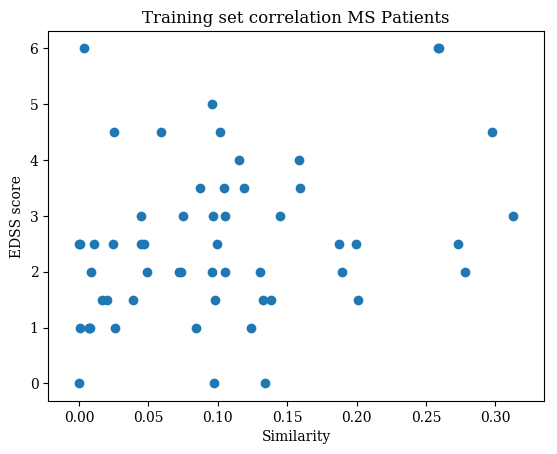

In [3430]:
# training set
"""plt.scatter(tr_sim, edss_tr)
plt.xlabel("Similarity")
plt.ylabel("EDSS score")
plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()"""

In [3431]:
# correlation on holdout set
"""np.corrcoef(ho_sim, edss_ho)"""

array([[ 1.        , -0.00577675],
       [-0.00577675,  1.        ]])

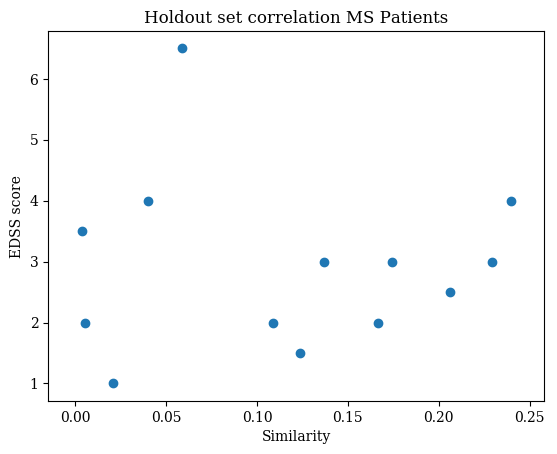

In [3432]:
# holdout set
"""plt.scatter(ho_sim, edss_ho)
plt.xlabel("Similarity")
plt.ylabel("EDSS score")
plt.title("Holdout set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()"""

In [3433]:
# correlation without highest two outliers
#tr_sim, edss_tr = np.concatenate([tr_sim[:np.argmax(tr_sim)], tr_sim[np.argmax(tr_sim)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_sim)], edss_tr[np.argmax(tr_sim)+1:]])
#tr_sim, edss_tr = np.concatenate([tr_sim[:np.argmax(tr_sim)], tr_sim[np.argmax(tr_sim)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_sim)], edss_tr[np.argmax(tr_sim)+1:]])
#np.corrcoef(tr_sim, edss_tr)

In [3434]:
# training set
#plt.scatter(tr_sim, edss_tr)
#plt.xlabel("Similarity")
#plt.ylabel("EDSS score")
#plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 200)
#plt.show()

### Correlation between lesion sum and EDSS

In [3435]:
# remove nans in both directions
"""tr_les, edss_tr = remove_nans_from_two_lists(training_lesion_sum, edss_list_train, base="latter")
tr_les, edss_tr = remove_nans_from_two_lists(tr_les, edss_tr, base="former")

ho_les, edss_ho = remove_nans_from_two_lists(holdout_lesion_sum, edss_list_holdout, base="latter")
ho_les, edss_ho = remove_nans_from_two_lists(ho_les, edss_ho, base="former")"""

58
56
13
13


In [3436]:
# correlation on training set
"""np.corrcoef(tr_les, edss_tr)"""

array([[1.        , 0.31938496],
       [0.31938496, 1.        ]])

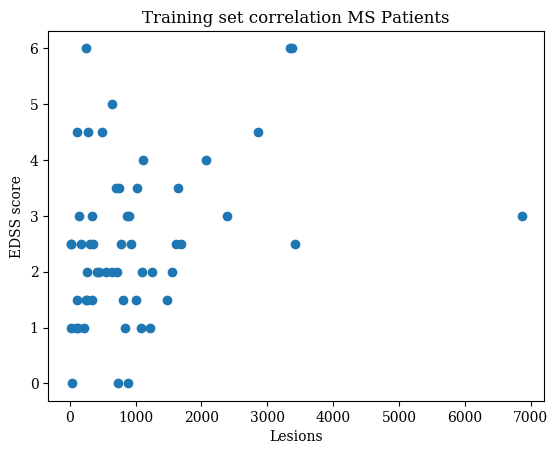

In [3437]:
"""# training set
plt.scatter(tr_les, edss_tr)
plt.xlabel("Lesions")
plt.ylabel("EDSS score")
plt.title("Training set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()"""

In [3438]:
# correlation without highest outlier
"""np.corrcoef(np.concatenate([tr_les[:np.argmax(tr_les)], tr_les[np.argmax(tr_les)+1:]]), np.concatenate([edss_tr[:np.argmax(tr_les)], edss_tr[np.argmax(tr_les)+1:]]))"""

array([[1.       , 0.3953995],
       [0.3953995, 1.       ]])

In [3439]:
# correlation on holdout set
"""np.corrcoef(ho_les, edss_ho)"""

array([[1.        , 0.01516586],
       [0.01516586, 1.        ]])

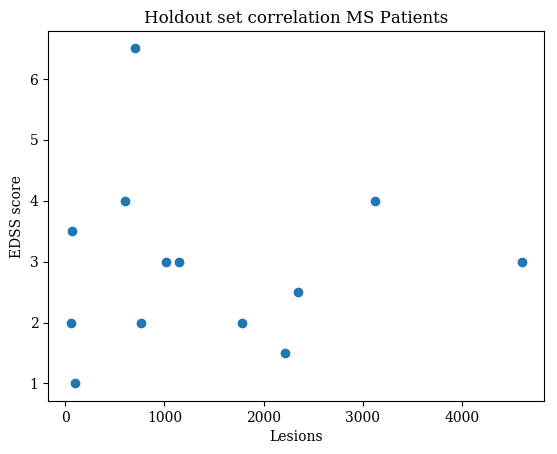

In [3440]:
# holdout set
"""plt.scatter(ho_les, edss_ho)
plt.xlabel("Lesions")
plt.ylabel("EDSS score")
plt.title("Holdout set correlation MS Patients")
#plt.xlim(-50, 130)
plt.show()"""

### Correlation between lesion amount and prediction/score

In [112]:
# Get heatmaps of all subjects
heatmap_list_holdout = get_heatmap_list(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
heatmap_list_train = get_heatmap_list(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Make lists for comparisons

In [113]:
training_sim = []
training_lesion_sum = []
training_score_list = []
training_pred_list = []
training_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_train):
    lesions = lesion_masks_train[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_train[idx])
    training_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        training_lesion_sum.append(np.NaN)
    else:
        training_lesion_sum.append(np.sum(lesion_masks_train[idx]))
    score = fine_tuned_model.predict(train_loader[idx][0]).item()
    training_score_list.append(score)
    pred = int(score>= 0.5)
    training_pred_list.append(pred)
    # check if correctly classified
    if pred == train_loader[idx][1].item():
        training_true_pred_list.append(1)
    else:
        training_true_pred_list.append(0)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill sum with NaNs.


In [115]:
holdout_sim = []
holdout_lesion_sum = []
holdout_score_list = []
holdout_pred_list = []
holdout_true_pred_list = []

for idx, heatmap in enumerate(heatmap_list_holdout):
    lesions = lesion_masks_holdout[idx]
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesions, sign="positive", plot=False)
    #similarity /= np.sum(lesion_masks_holdout[idx])
    holdout_sim.append(similarity)
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, fill sum with NaNs.")
        holdout_lesion_sum.append(np.NaN)
    else:
        holdout_lesion_sum.append(np.sum(lesion_masks_holdout[idx]))
    score = fine_tuned_model.predict(test_loader[idx][0]).item()
    holdout_score_list.append(score)
    pred = int(score >= 0.5)
    holdout_pred_list.append(pred)
    # check if correctly classified
    if pred == test_loader[idx][1].item():
        holdout_true_pred_list.append(1)
    else:
        holdout_true_pred_list.append(0)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [116]:
# remove nans in both directions
tr_les, pred_tr = remove_nans_from_two_lists(training_lesion_sum, training_pred_list, base="former")
tr_les, score_tr = remove_nans_from_two_lists(training_lesion_sum, training_score_list, base="former")
tr_les, true_pred_tr = remove_nans_from_two_lists(training_lesion_sum, training_true_pred_list, base="former")

116
116
116


In [117]:
# correlation on training set
np.corrcoef(tr_les, pred_tr)

array([[1.        , 0.25490326],
       [0.25490326, 1.        ]])

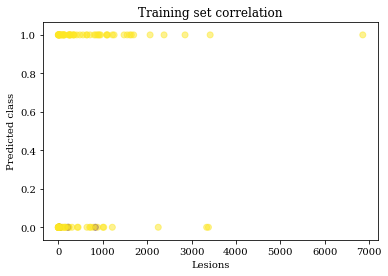

In [118]:
# training set
plt.scatter(tr_les, pred_tr, c=true_pred_tr, alpha=0.5)
plt.xlabel("Lesions")
plt.ylabel("Predicted class")
plt.title("Training set correlation")
#plt.xlim(-50, 130)
plt.show()

In [119]:
# correlation on training set
np.corrcoef(tr_les, score_tr)

array([[1.        , 0.26218612],
       [0.26218612, 1.        ]])

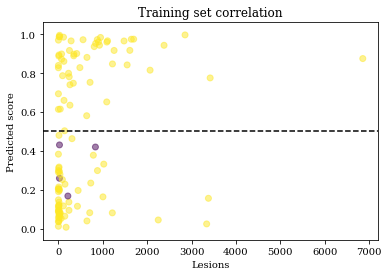

In [120]:
# training set
plt.scatter(tr_les, score_tr, c=true_pred_tr, alpha=0.5)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xlabel("Lesions")
plt.ylabel("Predicted score")
plt.title("Training set correlation")
#plt.legend("true", "false")
#plt.xlim(-50, 130)
plt.show()

In [121]:
# remove nans in both directions
ho_les, pred_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_pred_list, base="former")
ho_les, score_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_score_list, base="former")
ho_les, true_pred_ho = remove_nans_from_two_lists(holdout_lesion_sum, holdout_true_pred_list, base="former")

23
23
23


In [122]:
# correlation on holdout set
np.corrcoef(ho_les, pred_ho)

array([[1.        , 0.48388021],
       [0.48388021, 1.        ]])

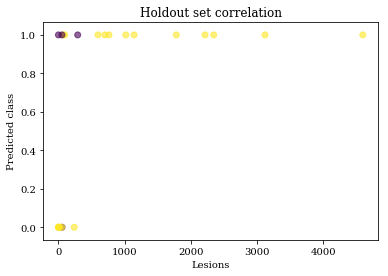

In [123]:
# hoaining set
plt.scatter(ho_les, pred_ho, c=true_pred_ho, alpha=0.6)
plt.xlabel("Lesions")
plt.ylabel("Predicted class")
plt.title("Holdout set correlation")
#plt.xlim(-50, 130)
plt.show()

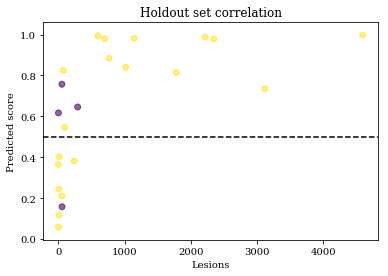

In [124]:
# holdout set
plt.scatter(ho_les, score_ho, c=true_pred_ho, alpha=0.6)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xlabel("Lesions")
plt.ylabel("Predicted score")
plt.title("Holdout set correlation")
#plt.xlim(-50, 130)
plt.show()

### Correlation between relevance and lesion amount

In [125]:
# Get all heatmaps of both HC and MS
heatmap_list_holdout = get_heatmap_list(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)
heatmap_list_train = get_heatmap_list(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=False)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [126]:
individual_relevance_sum = []
individual_lesion_sum = []
for relevance, lesions in zip(heatmap_list_train, lesion_masks_train):
    if np.max(lesions) != 1 and np.max(lesions) != 0 and np.min(lesions) != 0:
        print("Current lesion mask not available, skip.")
    else:
        individual_relevance_sum.append(np.sum(relevance))
        individual_lesion_sum.append(np.sum(lesions))

Current lesion mask not available, skip.
Current lesion mask not available, skip.
Current lesion mask not available, skip.
Current lesion mask not available, skip.


Text(0, 0.5, 'Relevance sum')

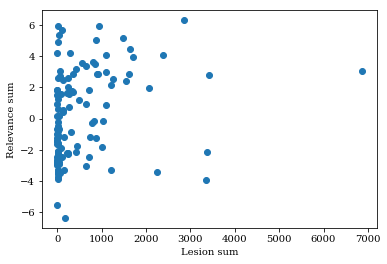

In [127]:
plt.scatter(individual_lesion_sum, individual_relevance_sum)
plt.xlabel("Lesion sum")
plt.ylabel("Relevance sum")
#plt.xlim(-50, 8000)

In [128]:
np.corrcoef(individual_lesion_sum, individual_relevance_sum)

array([[1.        , 0.27055098],
       [0.27055098, 1.        ]])

In [3301]:
# correlation without highest two outliers
#individual_lesion_sum, individual_relevance_sum = np.concatenate([individual_lesion_sum[:np.argmax(individual_lesion_sum)], individual_lesion_sum[np.argmax(individual_lesion_sum)+1:]]), np.concatenate([individual_relevance_sum[:np.argmax(individual_lesion_sum)], individual_relevance_sum[np.argmax(individual_lesion_sum)+1:]])
#individual_lesion_sum, individual_relevance_sum = np.concatenate([individual_lesion_sum[:np.argmax(individual_lesion_sum)], individual_lesion_sum[np.argmax(individual_lesion_sum)+1:]]), np.concatenate([individual_relevance_sum[:np.argmax(individual_lesion_sum)], individual_relevance_sum[np.argmax(individual_lesion_sum)+1:]])
#np.corrcoef(individual_lesion_sum, individual_relevance_sum)

In [3302]:
#plt.scatter(individual_lesion_sum, individual_relevance_sum)
#plt.xlabel("Lesion sum")
#plt.ylabel("Relevance sum")

### Relevance vs EDSS

In [3303]:
heatmap_list_train, edss_list_train = get_heatmap_list_with_edss(train_loader, shape, fine_tuned_beheaded_model, skip_healthy=True)
individual_relevance_sum = [np.sum(relevance) for relevance in heatmap_list_train]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3304]:
individual_relevance_sum, edss_list_train = remove_nans_from_two_lists(individual_relevance_sum, edss_list_train, base="latter")

58


In [3305]:
np.corrcoef(individual_relevance_sum, edss_list_train)

array([[1.        , 0.14378601],
       [0.14378601, 1.        ]])

Text(0, 0.5, 'EDSS score')

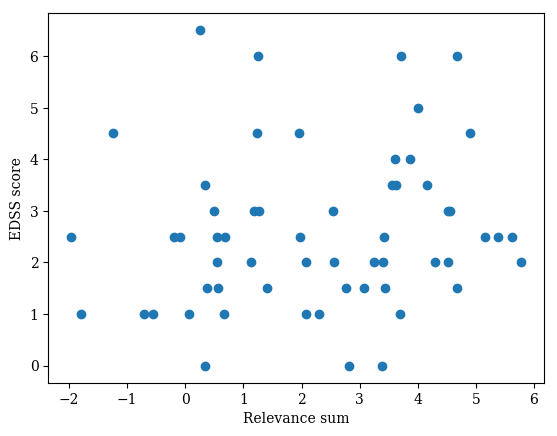

In [3306]:
plt.scatter(individual_relevance_sum, edss_list_train)
plt.xlabel("Relevance sum")
plt.ylabel("EDSS score")

## Signed Similiarty

### Training

In [136]:
print("Calculate positive training similarity")
pos_training_sim = []
for idx, heatmap in enumerate(heatmap_list_train):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_train[idx], sign="positive", plot=False)
    #similarity /= (np.sum(lesion_masks_train[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)    
    #similarity /= (np.sum(hm) + 1e-6)
    pos_training_sim.append(similarity)

print("Calculate negative training similarity")
neg_training_sim = []
for idx, heatmap in enumerate(heatmap_list_train):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_train[idx], sign="negative", plot=False)
    #similarity /= (np.sum(lesion_masks_train[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)
    #similarity /= (np.sum(hm) + 1e-6)
    neg_training_sim.append(similarity)

Calculate positive training similarity
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs
Calculate negative training similarity
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs
Current lesion mask not available, fill with NaNs


In [137]:
train_labels = np.array(y_train)

In [138]:
ms_sim_pos = []
for sim, y in zip(pos_training_sim, train_labels):
    if y == 1:
        ms_sim_pos.append(sim)
        
ms_sim_neg = []
for sim, y in zip(neg_training_sim, train_labels):
    if y == 1:
        ms_sim_neg.append(sim)

In [139]:
ms_sim_pos

[0.003447617320336424,
 0.00048056993564910537,
 0.014125831375566226,
 5.408173779558538e-05,
 0.0044550043965944286,
 0.02727087940741255,
 0.005171919389243581,
 0.010694160852634775,
 0.04817511221447557,
 0.011830022969486636,
 0.0017731433310531964,
 0.00616672351483819,
 0.007549424581062304,
 0.0007753735724110051,
 0.005557350059054627,
 0.0016551051431679164,
 0.0023710481851362012,
 0.006939024017963554,
 0.006709531920049796,
 0.004470210162175873,
 0.001552455214098275,
 0.00030269866710704556,
 0.0005594581475783043,
 nan,
 0.007754407196664854,
 0.003187153662609875,
 0.024232009605438885,
 0.023260014411349287,
 0.0014337592834404436,
 0.007761102189539006,
 0.0006893618168464717,
 4.654591701222824e-05,
 0.0001439039822967879,
 0.006292176920613939,
 0.0,
 0.0020557396899027473,
 0.00443505947785214,
 0.0019795394928584435,
 0.041995432900922565,
 0.005692738969461675,
 0.00011480631618202788,
 0.0,
 0.009130054813794962,
 0.031246049595988454,
 0.027633889841325438,
 

In [140]:
np.nanmean(ms_sim_pos)

0.006927348950595336

In [141]:
np.nanstd(ms_sim_pos)

0.010479291313229055

### On holdout

In [3494]:
heatmap_list_holdout, edss_list_holdout = get_heatmap_list_with_edss(test_loader, shape, fine_tuned_beheaded_model, skip_healthy=True)
individual_relevance_sum = [np.sum(relevance) for relevance in heatmap_list_holdout]

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [3495]:
individual_relevance_sum, edss_list_holdout = remove_nans_from_two_lists(individual_relevance_sum, edss_list_holdout, base="latter")

13


In [3496]:
np.corrcoef(individual_relevance_sum, edss_list_holdout)

array([[ 1.        , -0.03564663],
       [-0.03564663,  1.        ]])

Text(0, 0.5, 'EDSS score')

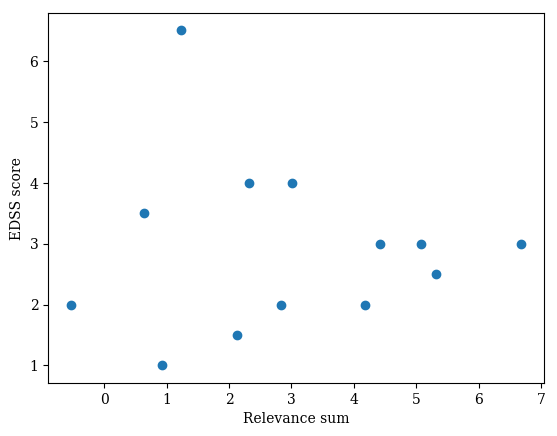

In [3497]:
plt.scatter(individual_relevance_sum, edss_list_holdout)
plt.xlabel("Relevance sum")
plt.ylabel("EDSS score")

In [130]:
print("Calculate positive holdout similarity")
pos_holdout_sim = []
for idx, heatmap in enumerate(heatmap_list_holdout):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_holdout[idx], sign="positive", plot=False)
    #similarity /= (np.sum(lesion_masks_holdout[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)    
    #similarity /= (np.sum(hm) + 1e-6)
    pos_holdout_sim.append(similarity)

print("Calculate negative holdout similarity")
neg_holdout_sim = []
for idx, heatmap in enumerate(heatmap_list_holdout):
    similarity = heatmap_lesion_similarity_sign(heatmap.squeeze(), lesion_masks_holdout[idx], sign="negative", plot=False)
    #similarity /= (np.sum(lesion_masks_holdout[idx]) + 1e-6)
    #hm = heatmap/np.max(heatmap)
    #similarity /= (np.sum(hm) + 1e-6)
    neg_holdout_sim.append(similarity)

Calculate positive holdout similarity
Calculate negative holdout similarity


In [131]:
holdout_labels = np.array(y_holdout)

In [132]:
ms_sim_pos = []
for sim, y in zip(pos_holdout_sim, holdout_labels):
    if y == 1:
        ms_sim_pos.append(sim)
        
ms_sim_neg = []
for sim, y in zip(neg_holdout_sim, holdout_labels):
    if y == 1:
        ms_sim_neg.append(sim)

In [133]:
ms_sim_pos

[0.0009978405943963683,
 0.0006555366992314685,
 0.0006878111508662288,
 0.01513754667342008,
 0.018876542383167258,
 0.01206871996590549,
 0.009911598981570392,
 0.0048114113675525524,
 0.008633910138024318,
 0.0025520396565378886,
 0.004760692908820073,
 0.012880333501092241,
 0.032117606552869896]

In [134]:
np.nanmean(ms_sim_pos)

0.00954550696718879

In [135]:
np.nanstd(ms_sim_pos)

0.008642734398197863